In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from matplotlib.colors import LogNorm

sns.set_theme()

# jupyter notebook full-width display
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# no text wrapping
display(HTML("<style>.dataframe td { white-space: nowrap; }</style>"))

# pandas formatting
pd.set_option('display.float_format', '{:.3f}'.format)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 200)

In [11]:
df_LF = pd.read_pickle('gaspereau_lengthfrequency.pickle')
df_FD = pd.read_pickle('gaspereau_fishdetails.pickle')
df_SD = pd.read_pickle('gaspereau_sample.pickle')
df_samplers = pd.read_pickle('gaspereau_samplers.pickle')

# Descriptive Stats

### Sample Dates vs Fish Detail and Length Frequency Dates
##### Percentages of Frozen vs Fresh date/sites that match
* look like these are sample dates, otherwise we would expect the opposite

In [12]:
frozen_ids = list(df_FD[df_FD.CONDITION=='Frozen'].sample_id.unique())
frozen_ids = [x for x in frozen_ids if x < 2024_00_00_00]
sum(df_SD.sample_id.isin(frozen_ids)) / len(frozen_ids)

0.8320707070707071

In [13]:
wet_ids = list(df_FD[df_FD.CONDITION=='Fresh'].sample_id.unique())
wet_ids = [x for x in wet_ids if x < 2024_00_00_00]
sum(df_SD.sample_id.isin(wet_ids)) / len(wet_ids)

0.7484848484848485

##### Simulation 
* check what percentage of sites would match randomly (to confirm sample date matches properly)

In [14]:
# older form of df_LF
df_LF_old = pd.read_csv(r'.\provided data\Margaree Gaspereau lgth-freq_Master.csv')

# convert all times to same format, set missing times to 0000 (date only), then to datetime format
df_LF_old['CleanTime'] = df_LF_old['Time']
df_LF_old.loc[df_LF_old['CleanTime'] < 10, 'CleanTime'] = df_LF_old.loc[df_LF_old['CleanTime'] < 10, 'CleanTime'] * 100
df_LF_old['CleanTime'] = pd.to_datetime(df_LF_old.CleanTime, format='%H%M')

# all null times should be 0000 (which pandas reads as no time data)
df_LF_old.loc[df_LF_old['CleanTime'].isnull(), 'CleanTime'] = pd.to_datetime(0)  

df_LF_old['DATETIME'] = pd.to_datetime(dict(
    year=df_LF_old['yy'], 
    month=df_LF_old['mm'], 
    day=df_LF_old['dd'], 
    hour=df_LF_old['CleanTime'].dt.hour, 
    minute=df_LF_old['CleanTime'].dt.minute
), errors='coerce')

df_LF_old = df_LF_old.drop('CleanTime', axis=1)

df_LF_old[['SITE1', 'SITE2', 'SITE3']] = df_LF_old.site.str.replace(' ','').str.split(',', expand=True).fillna(pd.NA)
df_LF_old = df_LF_old[df_LF_old.SITE1.notna()]

In [15]:
%%time

l_n_sites = list()
l_p_matches = list()

for i in range(1000):
    
    sample_sites = df_SD[df_SD.sample_date == df_SD.sample().sample_date.item()].SITE.unique()
    fish_sites = df_FD[df_FD.DATETIME == df_FD.sample().DATETIME.item()].SITE.unique()
    length_sites = df_LF_old[df_LF_old.DATETIME == df_LF_old.sample().DATETIME.item()].SITE1.unique()
    
    if len(sample_sites):
        p_match_FD = len([x for x in sample_sites if x in fish_sites]) / len(sample_sites)
        p_match_LF = len([x for x in sample_sites if x in length_sites]) / len(sample_sites)
    else:
        p_match_FD = 0
        p_match_LF = 0
    p_matches = (p_match_FD, p_match_LF)
    
    n_sites = (len(sample_sites), len(fish_sites), len(length_sites)) 
    l_n_sites.append(n_sites)
    l_p_matches.append(p_matches)
    

# display results
print('Proportions and Numbers of Matched Sites')
display(
    pd.concat([
        pd.DataFrame(l_p_matches, columns=['Fish Detail Match %', 'Length Freq Match %']), 
        pd.DataFrame(l_n_sites, columns=['No. Sample Sites', 'No. Fish Details Sites', 'No. Length Freq Sites'])
    ], axis=1).describe(percentiles=[.005, .025, .975, .995]).T[['min', '0.5%', 'mean', '99.5%', 'max']]  # 99% CI
)

# there is virtually no chance of as many matched samples/details/lengths
# unless sample dates are matched between spreadsheets

Proportions and Numbers of Matched Sites


,min,0.5%,mean,99.5%,max
Fish Detail Match %,0.000,0.000,0.083,0.500,1.000
Length Freq Match %,0.000,0.000,0.000,0.000,0.000
No. Sample Sites,0.000,1.000,14.159,37.000,37.000
No. Fish Details Sites,1.000,1.000,1.781,3.000,4.000
No. Length Freq Sites,1.000,1.000,1.771,3.000,4.000


Wall time: 7.14 s


### FISH DETAILS

In [16]:
df_FD.dtypes

sample_id                    Int64
DATETIME            datetime64[ns]
SITE                         Int32
PERIOD                      object
CONDITION                   object
fish_number                  Int32
FL_WET                       Int32
FL_FROZEN                    Int32
fish_length                  Int64
fish_weight                float64
SPECIES                     object
SEX                         object
maturity_id                  Int32
gonad_weight               float64
AGER_1                      object
AGE_1                        Int32
FSP_1                        Int32
COMMENTS_1                  object
AGER_2                      object
AGE_2                        Int32
FSP_2                        Int32
COMMENTS_2                  object
AGER_3                      object
AGE_3                        Int32
FSP_3                        Int32
COMMENTS_3                  object
ENVELOP_COMMENTS            object
remarks                     object
dtype: object

In [17]:
df_FD.describe(include='all', datetime_is_numeric=False).T

C:\Users\CARRK\AppData\Local\Temp\1\ipykernel_11992\503964342.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df_FD.describe(include='all', datetime_is_numeric=False).T


,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
sample_id,36912.000,NaN,NaN,NaN,NaT,NaT,2029667941.122,165473895.652,1983050912.000,1992052201.000,2001052541.000,2013061147.000,3014053047.000
DATETIME,36912,783,1996-06-05 00:00:00,158,1983-05-09,2021-06-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SITE,36794.000,NaN,NaN,NaN,NaT,NaT,27.553,18.076,1.000,12.000,26.000,41.000,95.000
PERIOD,31710,3,AM,16927,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CONDITION,36717,2,Frozen,25882,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
fish_number,36912.000,NaN,NaN,NaN,NaT,NaT,17.756,11.620,1.000,9.000,17.000,25.000,100.000
FL_WET,10848.000,NaN,NaN,NaN,NaT,NaT,251.842,19.691,150.000,238.000,251.000,265.000,358.000
FL_FROZEN,25590.000,NaN,NaN,NaN,NaT,NaT,247.265,19.583,112.000,234.000,247.000,260.000,366.000
fish_length,36438.000,NaN,NaN,NaN,NaT,NaT,254.259,19.812,118.000,241.000,254.000,268.000,376.000
fish_weight,36609.000,NaN,NaN,NaN,NaT,NaT,216.571,60.731,15.100,173.000,210.000,254.000,539.000


In [18]:
for col in df_FD.columns:
    print()
    print(col)
    if df_FD[col].nunique() > 100:
        print('number of unique values:', df_FD[col].nunique())
    else:
        print(df_FD[col].unique())


sample_id
number of unique values: 1145

DATETIME
number of unique values: 783

SITE
<IntegerArray>
[  12,    8,    5,   49,    9,   46,   25,   33,    2,   17,   39,   38,    7,
   37,   51,   11,   64,   35,   56, <NA>,   15,   48,    4,   34,   23,   67,
    1,   26,   28,    6,   52,   29,   90,   60,   41,   27,   47,   14,   30,
   62,   95,   92,   93,   94]
Length: 44, dtype: Int32

PERIOD
[nan 'AM' 'PM' 'AD']

CONDITION
['Fresh' 'Frozen' nan]

fish_number
<IntegerArray>
[  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,  14,  15,
  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,  28,  29,  30,
  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,  42,  43,  44,  45,
  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,  56,  57,  58,  59,  60,
  61,  62,  63,  64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,
  76,  77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
  91,  92,  93,  94,  95,  96,  97,  98,  99, 100]
Length: 

In [19]:
df_FD[df_FD.gonad_weight.notna()].groupby('SEX').count()['sample_id']

SEX
B        1
F    16986
M      622
U      324
Name: sample_id, dtype: int64

In [20]:
df_FD[df_FD.gonad_weight.isnull()].groupby('SEX').count()['sample_id']

SEX
F     1315
M    16963
U      473
Name: sample_id, dtype: int64

### SAMPLES

In [21]:
df_SD.dtypes

sample_id                        Int64
sample_date             datetime64[ns]
district_id                      int64
RIVER                           object
SAMPLER                         object
CODE                            object
gear_id                          int64
SITE                             Int64
NO_NETS                         object
catch_weight_lbs               float64
HOURS_FISHED                   float64
ZONE                            object
LAST_NAME                       object
COMMENTS                        object
BYCATCH_SBASS                  float64
BYCATCH_SHAD                   float64
BYCATCH_OTHER                   object
remarks                         object
total_fish_preserved           float64
total_fish_measured            float64
sample_weight_lbs              float64
dtype: object

In [22]:
df_SD.describe(include='all', datetime_is_numeric=False).T

C:\Users\CARRK\AppData\Local\Temp\1\ipykernel_11992\3166899065.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df_SD.describe(include='all', datetime_is_numeric=False).T


,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
sample_id,15213.000,NaN,NaN,NaN,NaT,NaT,2005619169.619,208980163.208,1983041833.000,1990051764.000,2000051151.000,2010050149.000,13988040037.000
sample_date,15182,1568,1989-05-19 00:00:00,37,1983-04-18,2019-06-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN
district_id,15213.000,NaN,NaN,NaN,NaT,NaT,2.000,0.000,2.000,2.000,2.000,2.000,2.000
RIVER,15213,1,SWMARG,15213,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SAMPLER,15213,74,Martin E Cameron,1209,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CODE,0,0,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
gear_id,15213.000,NaN,NaN,NaN,NaT,NaT,81.000,0.000,81.000,81.000,81.000,81.000,81.000
SITE,15213.000,NaN,NaN,NaN,NaT,NaT,31.198,18.873,1.000,15.000,30.000,47.000,91.000
NO_NETS,9623,2,1,9574,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
catch_weight_lbs,15200.000,NaN,NaN,NaN,NaT,NaT,1696.968,4365.462,0.000,100.000,400.000,1400.000,95200.000


In [23]:
for col in df_SD.columns:
    print()
    print(col)
    if df_SD[col].nunique() > 100:
        print('number of unique values:', df_SD[col].nunique())
    else:
        print(df_SD[col].unique())


sample_id
number of unique values: 15213

sample_date
number of unique values: 1568

district_id
[2]

RIVER
['SWMARG']

SAMPLER
['Michael J Stewart' 'Martin E Cameron' 'Hugh J Gillis' 'Colin Gillis'
 'Darlene Cameron' 'Donald J Gillis' 'Irene MacIsaac' 'John A Coady'
 'Gerard MacFarlane' 'John Coady' 'Jim Coady' 'Fred Ingram'
 'Allan B Gillis' 'Michael D Gillis' 'Mary E Gillis' 'Brian Doyle'
 'John A Chisholm' 'James A Hirtle' 'John MacLellan' 'Alexander MacDonald'
 'Mary C Gillis' 'Donald D Gillis' 'Donald M Campbell' 'Donelda M Gillis'
 'Robert Gillis' 'John R Gillis' 'Alexander Gillis' 'Joseph M MacFarlane'
 'John H Gillis' 'Brian MacFarlane' 'Joseph Mackinnon' 'Neil McDaniel'
 'Robert MacLeod' 'Catherine MacLeod' 'Josephine MacDonald'
 'John Neil Gillis' 'Finley MacDonald' 'Donald MacEachern' 'Robert Peters'
 'Harold MacFarlane' 'Richard Gillis' 'Anthony Cameron'
 'Gerard V Chiasson' 'Eleanor MacLellan' 'John V MacKinnon'
 'David MacKinnon' 'Charles McDaniel' 'Bruce MacLellan'
 'C

### LENGTH FREQUENCIES

In [24]:
df_LF.dtypes

count              int64
length_bin_id    float64
sample_id          Int64
dtype: object

In [25]:
df_LF.describe(include='all', datetime_is_numeric=False).T

,count,mean,std,min,25%,50%,75%,max
count,11127.000,18.452,18.214,0.000,3.000,12.000,30.000,117.000
length_bin_id,11127.000,25.101,2.156,14.500,23.500,25.000,26.500,32.000
sample_id,11127.000,2042118269.515,247119065.997,1990050712.000,1995060826.000,2004052817.000,2013062741.000,4018061364.000


In [26]:
for col in df_LF.columns:
    print()
    print(col)
    if df_LF[col].nunique() > 100:
        print('number of unique values:', df_LF[col].nunique())
    else:
        print(df_LF[col].unique())


count
number of unique values: 101

length_bin_id
[25.  25.5 26.  26.5 27.  27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5
 24.5 24.  32.  23.  23.5 22.5 22.  21.5 21.  20.  20.5 19.5 14.5 15.5]

sample_id
number of unique values: 917


# Data Visualisation

In [27]:
def types_of_data(series):
    
    numbers, strings, blanks, n_null = 0, 0, 0, 0
    
    for item in series:
        if pd.isnull(item):
            n_null += 1
        else:
            try:
                float(item)
                numbers += 1
            except (ValueError):
                strings += 1
                if str(item) == ' ' or str(item) == '':
                    blanks += 1
                
    # note: blanks are strings
    return numbers, strings, blanks, n_null


def print_data_info(dataframe, column):
    
    print('\n--------------------------------------------------\nData Info:', column.upper(), '\n')
    
    numbers, strings, blanks, n_null = types_of_data(dataframe[column])
    
    print('UNIQUE numbers, strings, blanks, null =', types_of_data(dataframe[column].unique()))
    print('number of numeric =', numbers)
    print('number of strings =', strings)
    print('number of blanks =', blanks)  # blanks are strings
    print('number of null = ', n_null)
    print('check: ', numbers + strings + n_null, '==', dataframe[column].shape[0])

    
def print_hist(dataframe, column, max_bins=100, colours=(0,2)):
    
    print('\n--------------------------------------------------\nHistogram:', column.upper())
    
    plt.figure(figsize=(14, 4))
    
    n_unique = dataframe[column].nunique()
    if n_unique <= max_bins:
        bins = n_unique
    else:
        bins = max_bins
    
    # if there are too many bins, rotate the text to make it readable
    if bins > 20:
        xrot = 90
    else:
        xrot = 0
        
    is_categorical = dataframe[column].dtype == 'object'
    if is_categorical:
        plot = dataframe[column].astype(str).sort_values().hist(
            bins=bins, xrot=90, color=sns.color_palette()[colours[1]]
        )
    else:
        plot = dataframe[column].hist(
            bins=bins, xrot=0, color=sns.color_palette()[colours[0]]
        )
    
    plot.yaxis.tick_right()  # so all of the graphs align with eachother, regarless of text length
    plt.show()
    
    
def print_timeseries(dataframe, column, time_column, colours=(1,3)):
    
    print('\n------------------------------------------------\nTime Series:', column.upper(), sep='')
    
    plt.figure(figsize=(14, 4))
    
    # could make the categorical check an input variable, but this just works (albiet super clean)
    try:
        plot = sns.lineplot(
            x = dataframe[time_column].dt.year, 
            y = dataframe[column].astype(float),  # cast int to float or get ValueErrors with IQR (pi 50)
            errorbar = ('pi', 50),  # IQR
            color = sns.color_palette()[colours[0]]
        )
        print('NUMERICAL')  # NOTE: some are actually categorical but stored as an int(eg, site), those averages don't have meaning
    except (ValueError, TypeError):  # categorical variables, can't cast to float
        plot = sns.lineplot(
            x = dataframe[time_column].dt.year, 
            y = dataframe[column].astype(str).sort_values(),
            errorbar = ('pi', 50), 
            color = sns.color_palette()[colours[1]]
        )
        print('CATEGORICAL')  # NOTE: categorical variables treated as ordinal to make plotting possible, averages don't have meaning
       
    
    # show entire dataset time period for all plots
    plot.set_xlim(1982, 2022)
    plot.yaxis.tick_right()  # so all of the graphs align with eachother, regarless of text length
    
    plt.show()
    
    
def do_EDA_stuff(dataframe, column, date_column='DATETIME'):
    """default of datetime column name 'DATETIME' often used, can be overwritten"""
    print_data_info(dataframe, column)
    print_hist(dataframe, column)
    print_timeseries(dataframe, column, date_column)

### FISH DETAILS

In [28]:
df_FD.columns

Index(['sample_id', 'DATETIME', 'SITE', 'PERIOD', 'CONDITION', 'fish_number',
       'FL_WET', 'FL_FROZEN', 'fish_length', 'fish_weight', 'SPECIES', 'SEX',
       'maturity_id', 'gonad_weight', 'AGER_1', 'AGE_1', 'FSP_1', 'COMMENTS_1',
       'AGER_2', 'AGE_2', 'FSP_2', 'COMMENTS_2', 'AGER_3', 'AGE_3', 'FSP_3',
       'COMMENTS_3', 'ENVELOP_COMMENTS', 'remarks'],
      dtype='object')


--------------------------------------------------
Data Info: SITE 

UNIQUE numbers, strings, blanks, null = (43, 0, 0, 1)
number of numeric = 36794
number of strings = 0
number of blanks = 0
number of null =  118
check:  36912 == 36912

--------------------------------------------------
Histogram: SITE


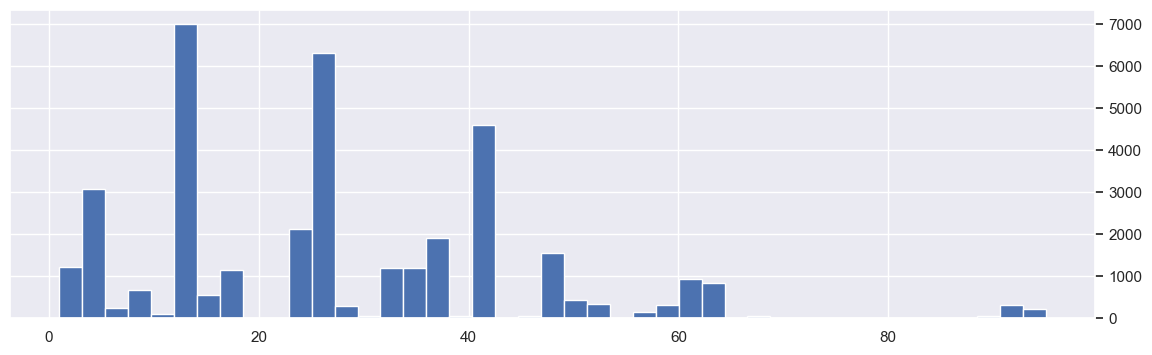


------------------------------------------------
Time Series:SITE
NUMERICAL


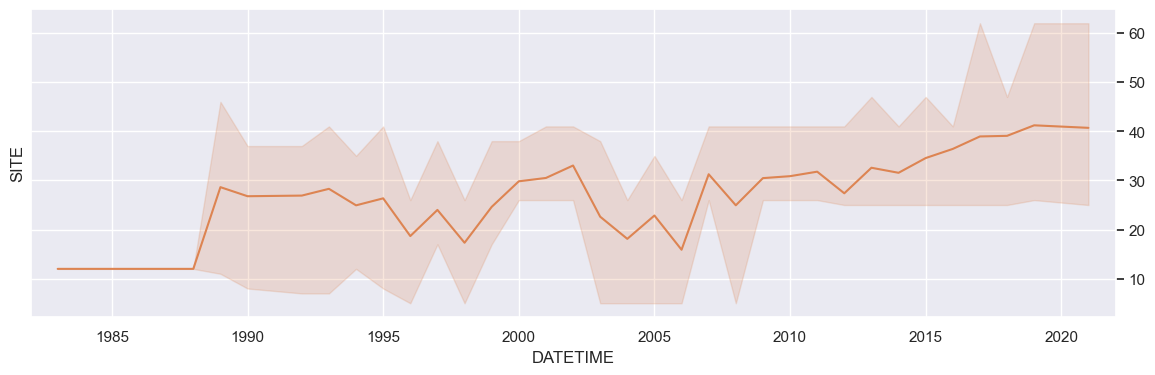


--------------------------------------------------
Data Info: PERIOD 

UNIQUE numbers, strings, blanks, null = (0, 3, 0, 1)
number of numeric = 0
number of strings = 31710
number of blanks = 0
number of null =  5202
check:  36912 == 36912

--------------------------------------------------
Histogram: PERIOD


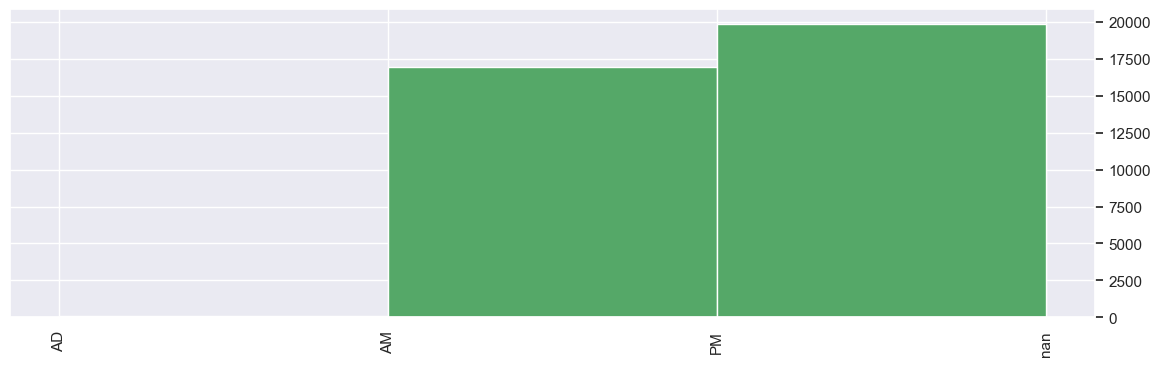


------------------------------------------------
Time Series:PERIOD
CATEGORICAL


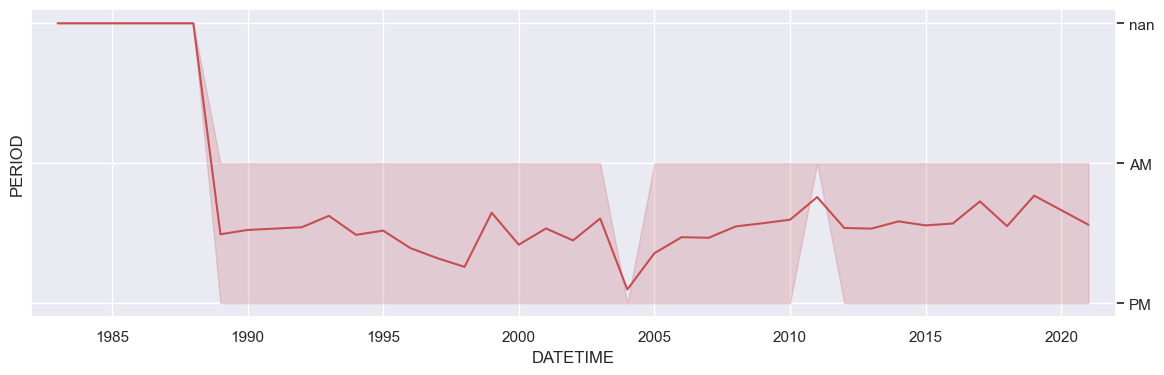


--------------------------------------------------
Data Info: CONDITION 

UNIQUE numbers, strings, blanks, null = (0, 2, 0, 1)
number of numeric = 0
number of strings = 36717
number of blanks = 0
number of null =  195
check:  36912 == 36912

--------------------------------------------------
Histogram: CONDITION


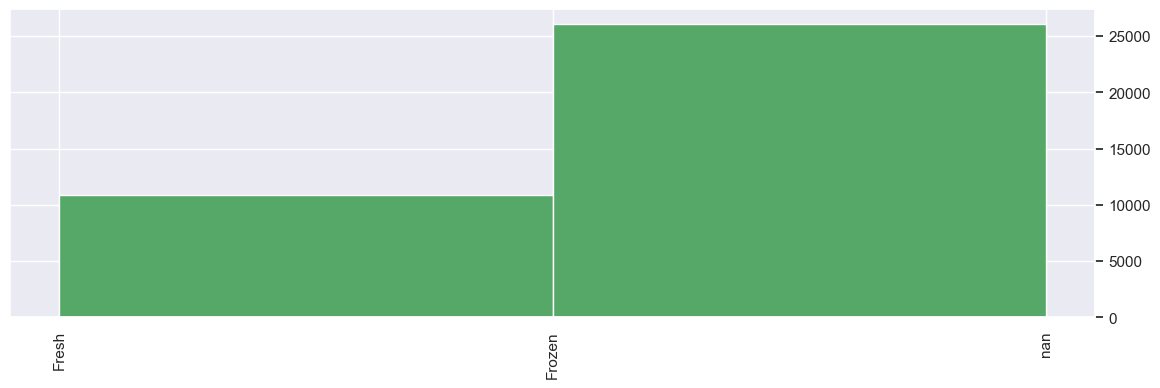


------------------------------------------------
Time Series:CONDITION
CATEGORICAL


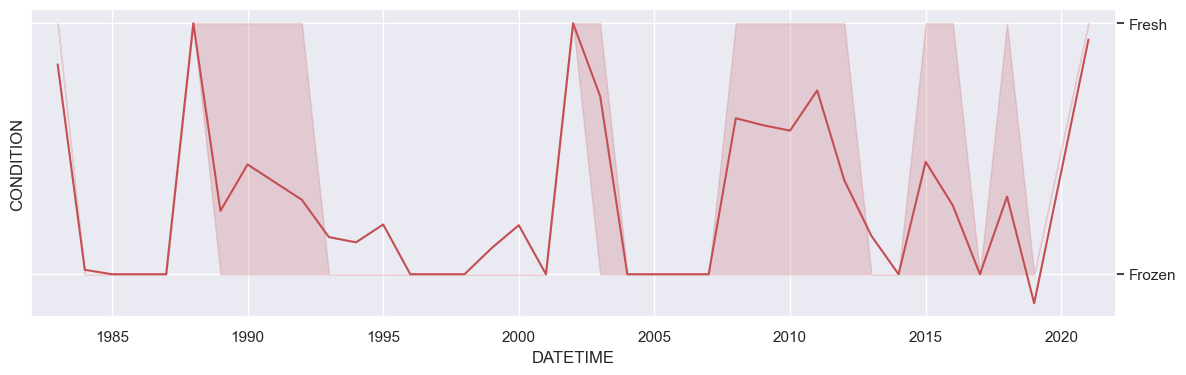


--------------------------------------------------
Data Info: FISH_NUMBER 

UNIQUE numbers, strings, blanks, null = (100, 0, 0, 0)
number of numeric = 36912
number of strings = 0
number of blanks = 0
number of null =  0
check:  36912 == 36912

--------------------------------------------------
Histogram: FISH_NUMBER


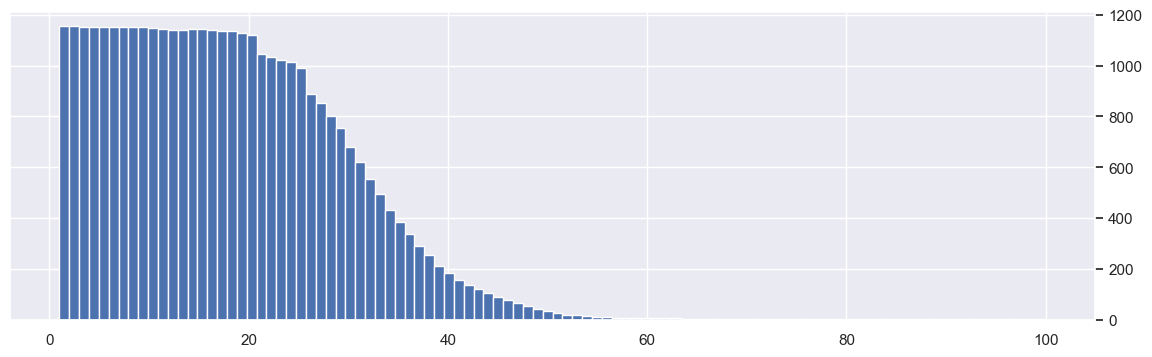


------------------------------------------------
Time Series:FISH_NUMBER
NUMERICAL


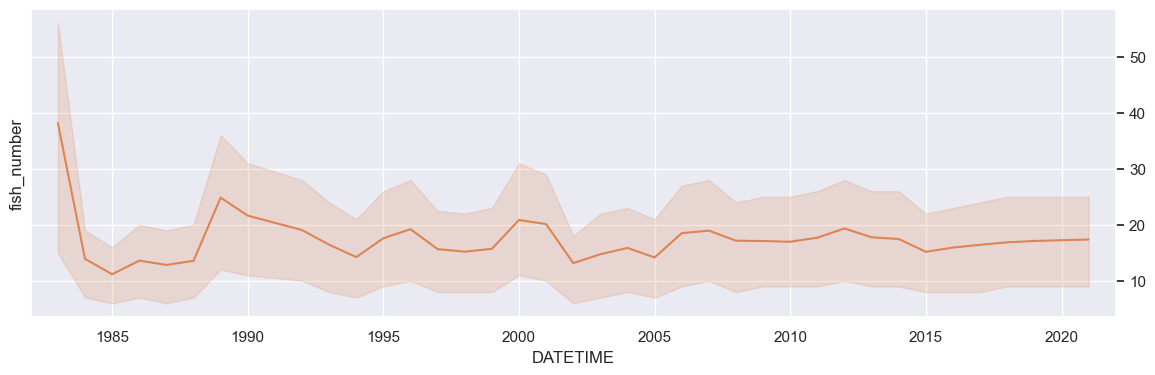


--------------------------------------------------
Data Info: FL_WET 

UNIQUE numbers, strings, blanks, null = (120, 0, 0, 1)
number of numeric = 10848
number of strings = 0
number of blanks = 0
number of null =  26064
check:  36912 == 36912

--------------------------------------------------
Histogram: FL_WET


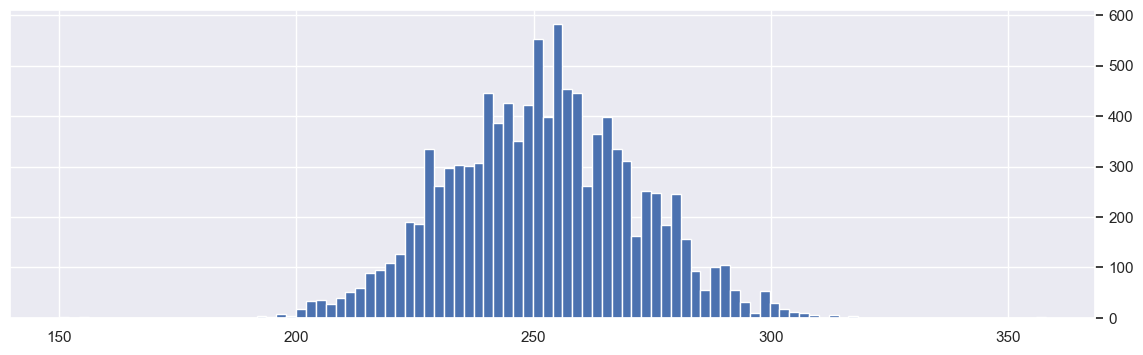


------------------------------------------------
Time Series:FL_WET
NUMERICAL


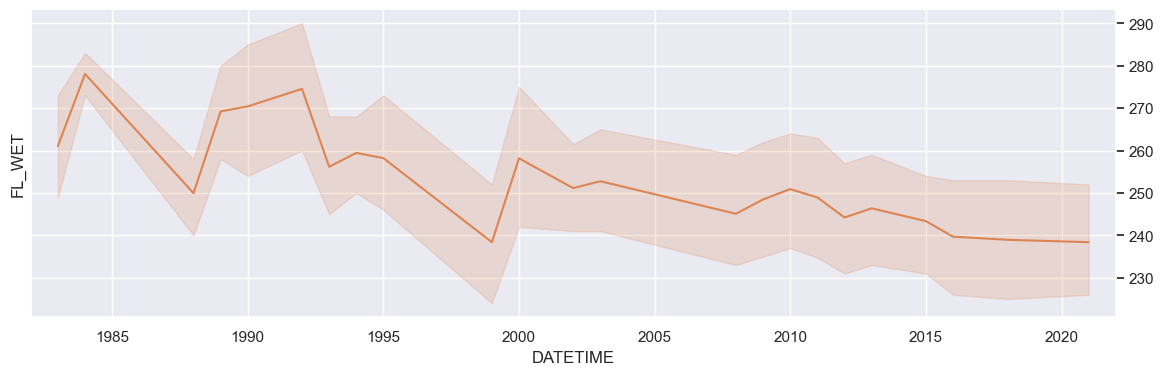


--------------------------------------------------
Data Info: FL_FROZEN 

UNIQUE numbers, strings, blanks, null = (141, 0, 0, 1)
number of numeric = 25590
number of strings = 0
number of blanks = 0
number of null =  11322
check:  36912 == 36912

--------------------------------------------------
Histogram: FL_FROZEN


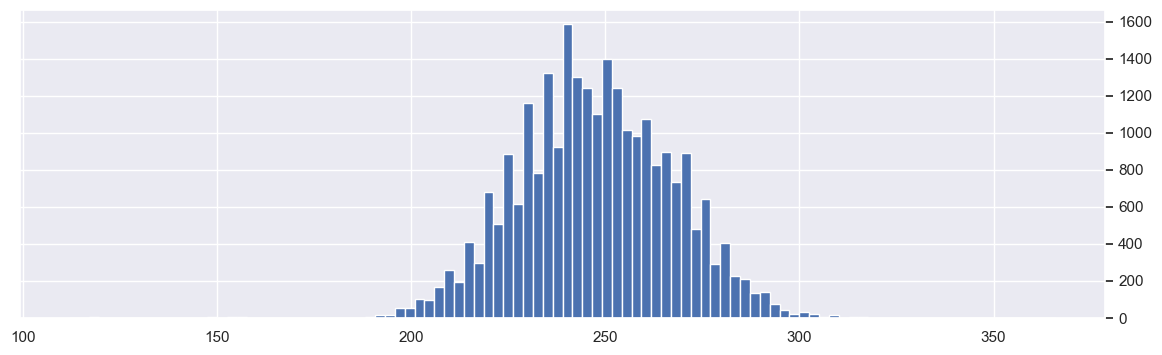


------------------------------------------------
Time Series:FL_FROZEN
NUMERICAL


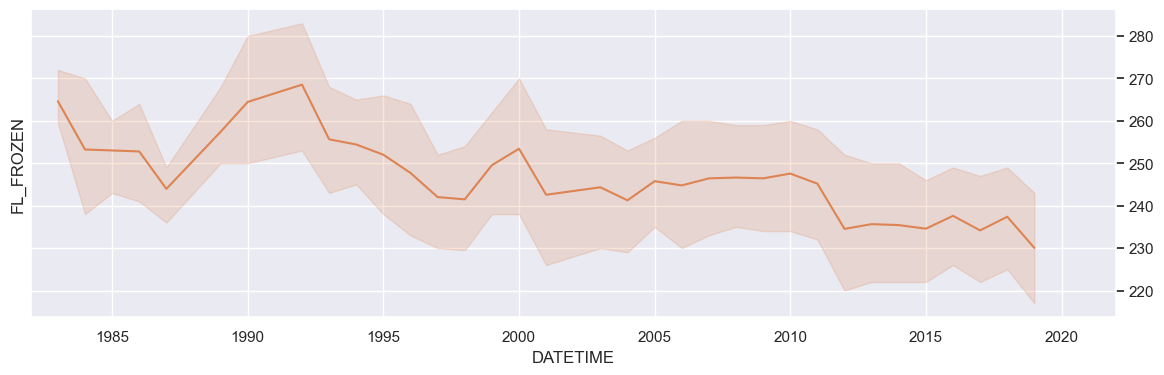


--------------------------------------------------
Data Info: FISH_LENGTH 

UNIQUE numbers, strings, blanks, null = (150, 0, 0, 1)
number of numeric = 36438
number of strings = 0
number of blanks = 0
number of null =  474
check:  36912 == 36912

--------------------------------------------------
Histogram: FISH_LENGTH


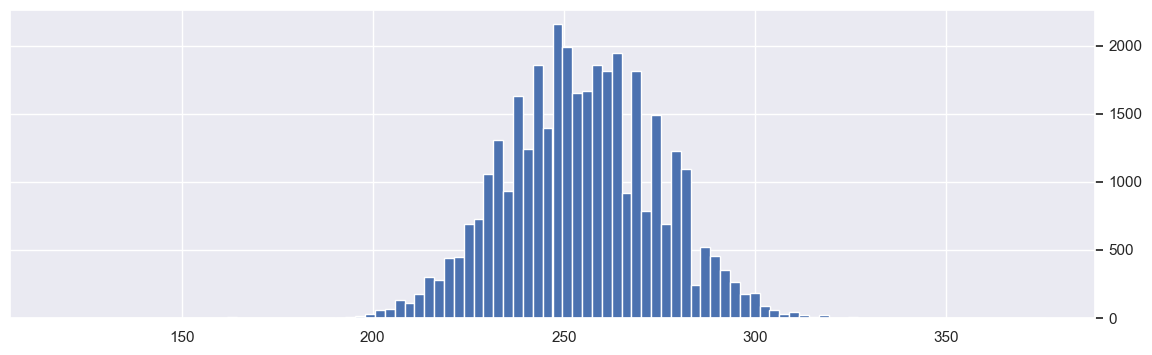


------------------------------------------------
Time Series:FISH_LENGTH
NUMERICAL


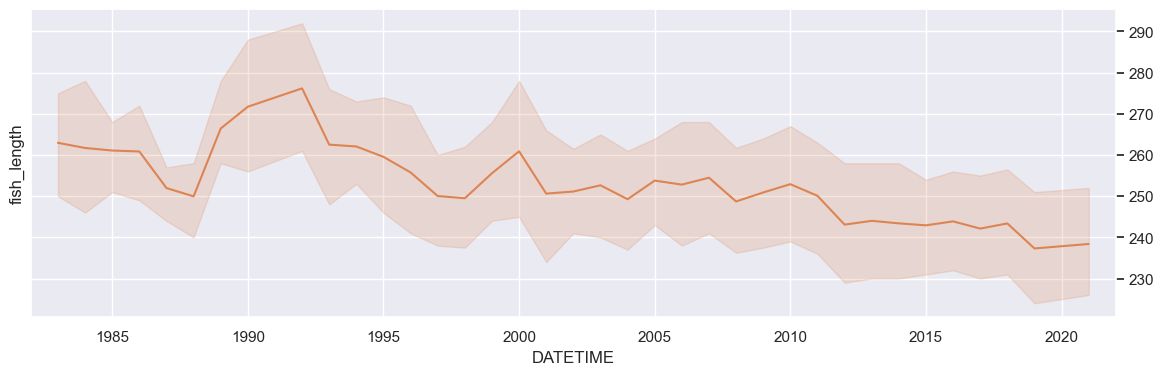


--------------------------------------------------
Data Info: FISH_WEIGHT 

UNIQUE numbers, strings, blanks, null = (2717, 0, 0, 1)
number of numeric = 36609
number of strings = 0
number of blanks = 0
number of null =  303
check:  36912 == 36912

--------------------------------------------------
Histogram: FISH_WEIGHT


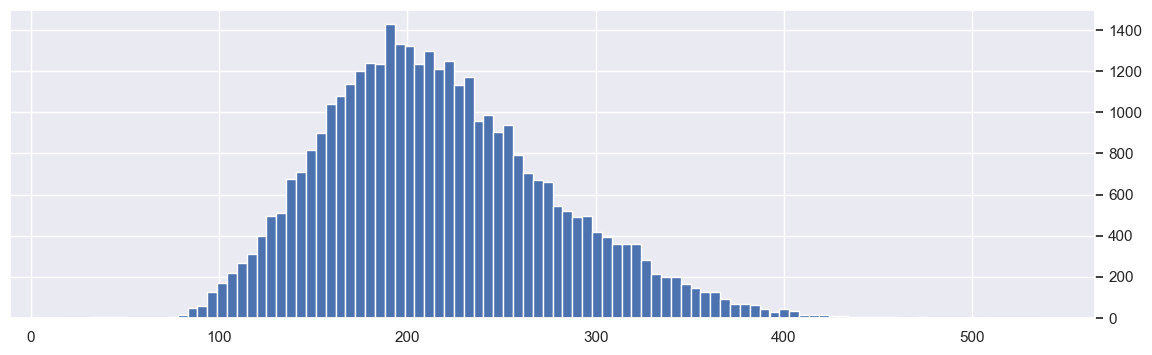


------------------------------------------------
Time Series:FISH_WEIGHT
NUMERICAL


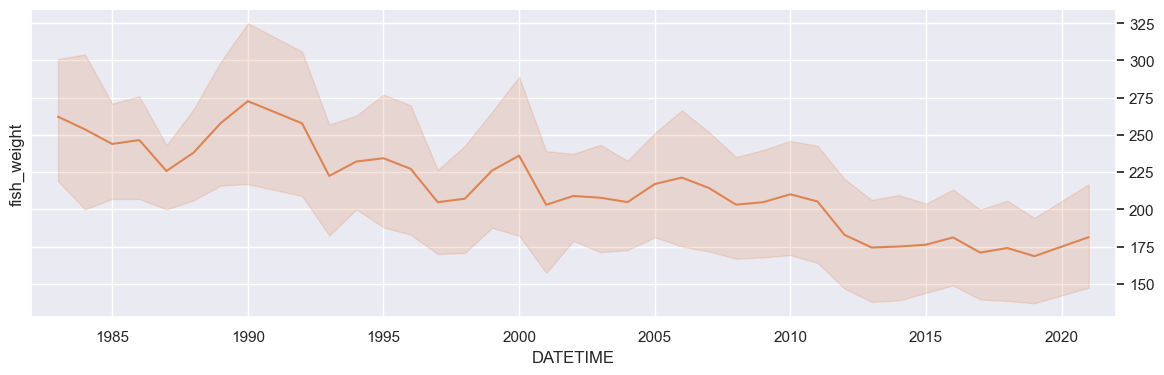


--------------------------------------------------
Data Info: SPECIES 

UNIQUE numbers, strings, blanks, null = (0, 3, 0, 1)
number of numeric = 0
number of strings = 36685
number of blanks = 0
number of null =  227
check:  36912 == 36912

--------------------------------------------------
Histogram: SPECIES


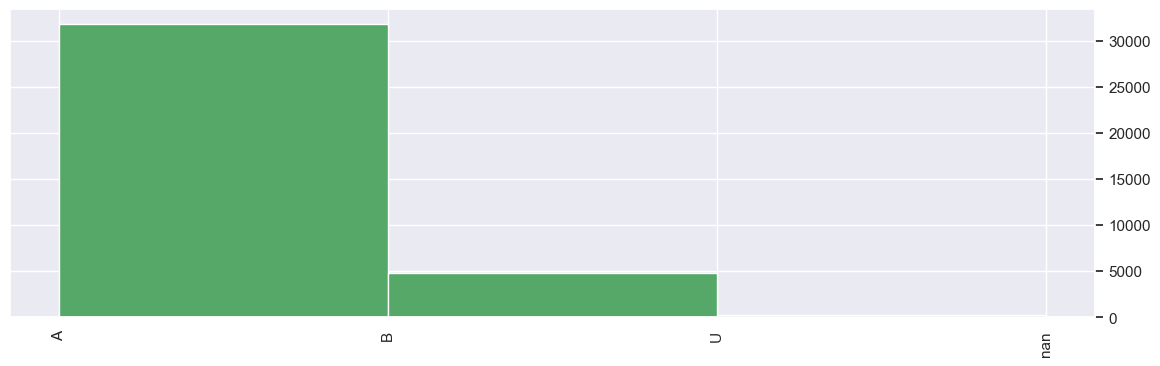


------------------------------------------------
Time Series:SPECIES
CATEGORICAL


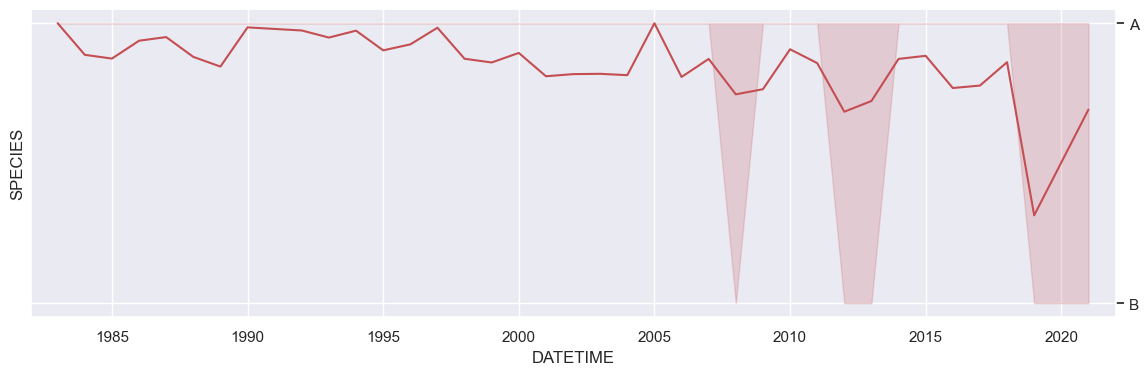


--------------------------------------------------
Data Info: SEX 

UNIQUE numbers, strings, blanks, null = (0, 4, 0, 1)
number of numeric = 0
number of strings = 36684
number of blanks = 0
number of null =  228
check:  36912 == 36912

--------------------------------------------------
Histogram: SEX


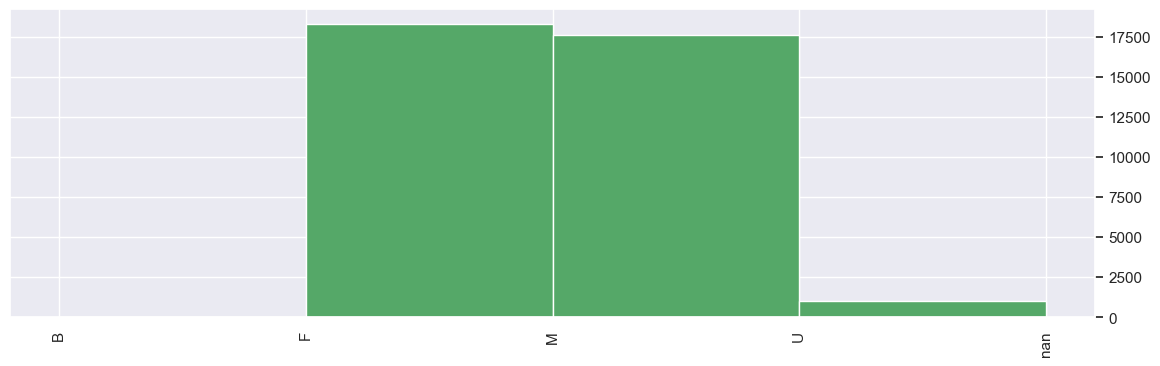


------------------------------------------------
Time Series:SEX
CATEGORICAL


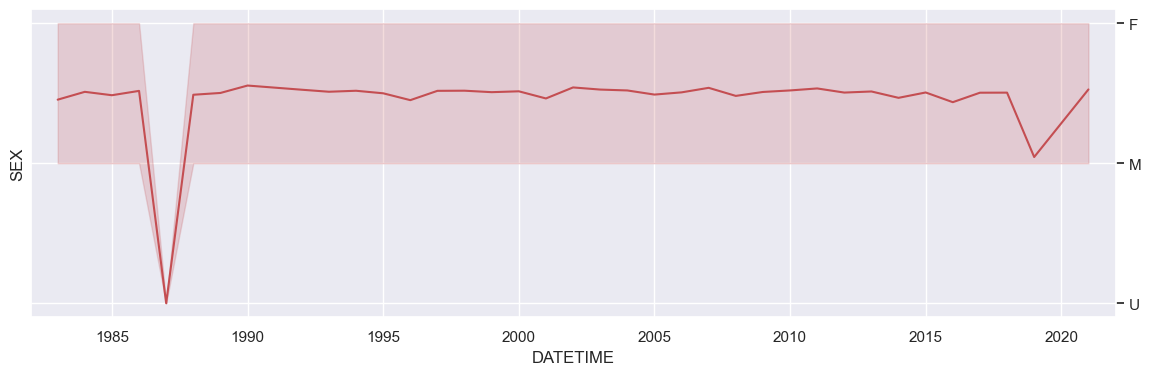


--------------------------------------------------
Data Info: MATURITY_ID 

UNIQUE numbers, strings, blanks, null = (6, 0, 0, 1)
number of numeric = 36283
number of strings = 0
number of blanks = 0
number of null =  629
check:  36912 == 36912

--------------------------------------------------
Histogram: MATURITY_ID


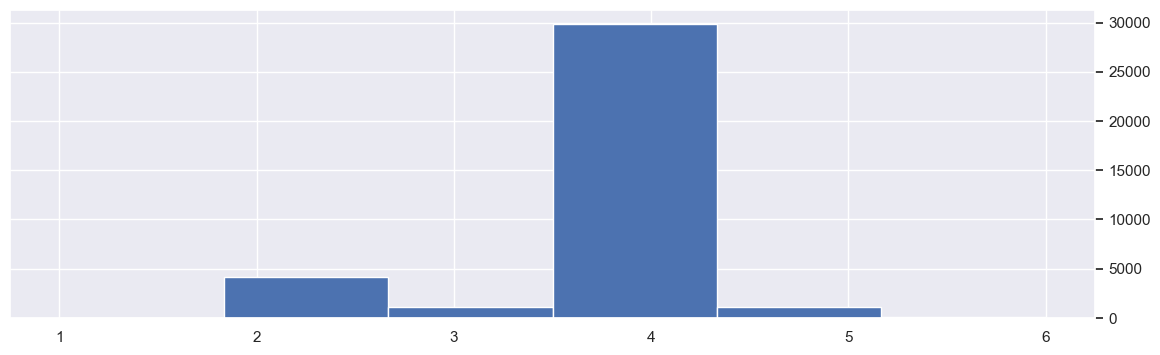


------------------------------------------------
Time Series:MATURITY_ID
NUMERICAL


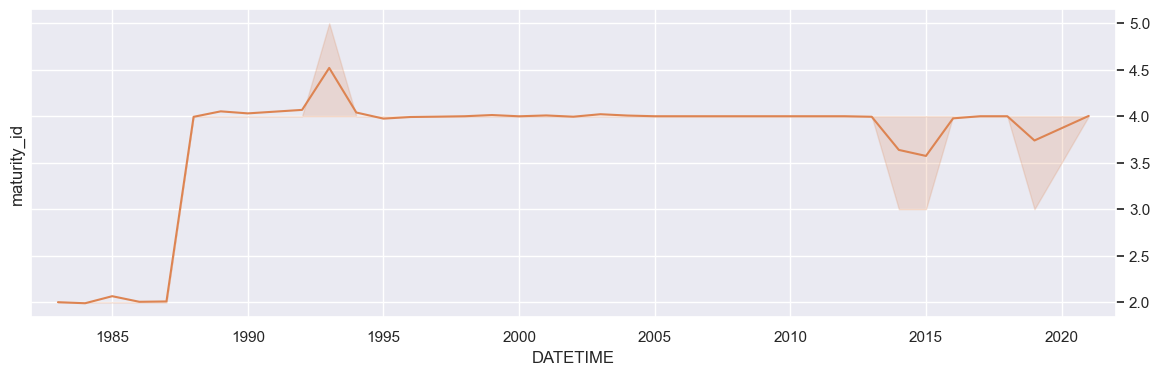


--------------------------------------------------
Data Info: GONAD_WEIGHT 

UNIQUE numbers, strings, blanks, null = (802, 0, 0, 1)
number of numeric = 17933
number of strings = 0
number of blanks = 0
number of null =  18979
check:  36912 == 36912

--------------------------------------------------
Histogram: GONAD_WEIGHT


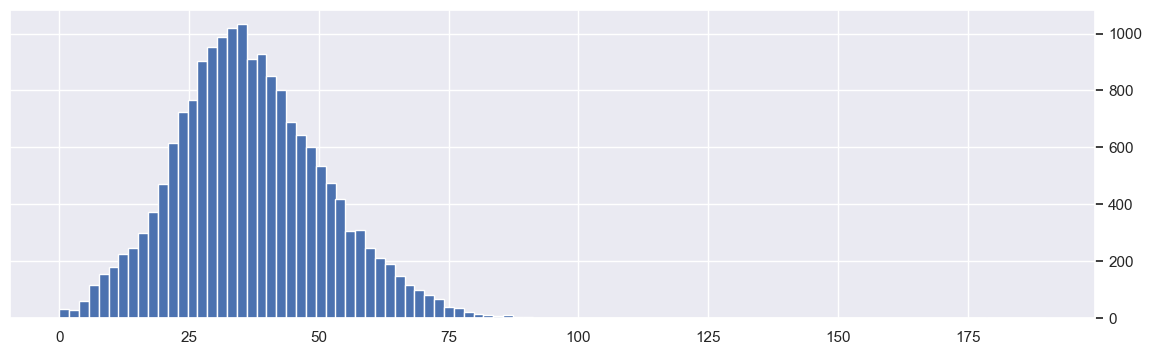


------------------------------------------------
Time Series:GONAD_WEIGHT
NUMERICAL


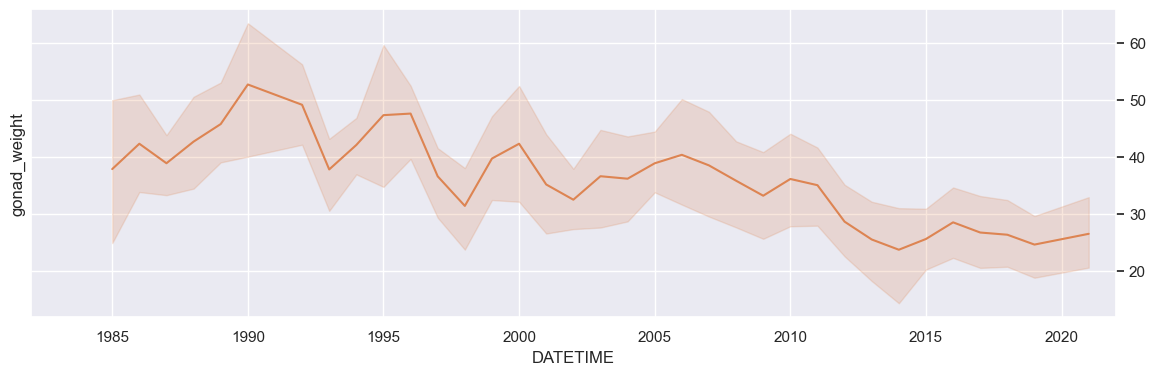


--------------------------------------------------
Data Info: AGER_1 

UNIQUE numbers, strings, blanks, null = (0, 1, 0, 1)
number of numeric = 0
number of strings = 7118
number of blanks = 0
number of null =  29794
check:  36912 == 36912

--------------------------------------------------
Histogram: AGER_1


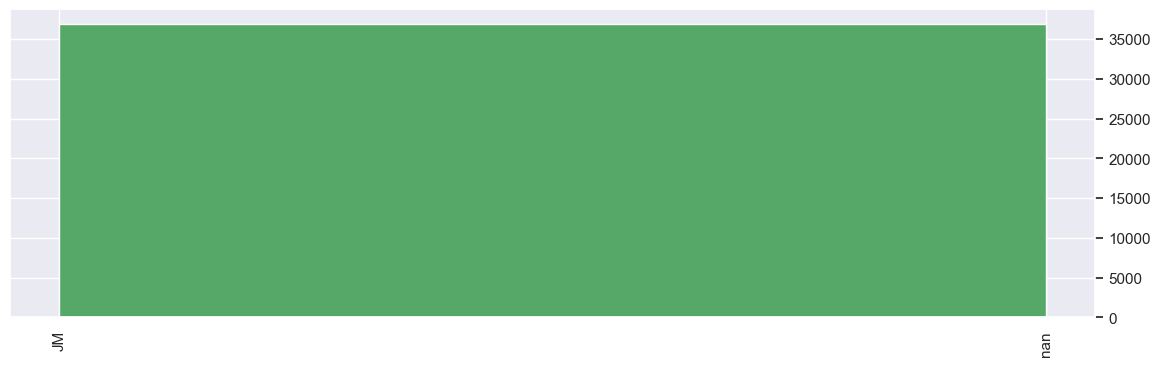


------------------------------------------------
Time Series:AGER_1
CATEGORICAL


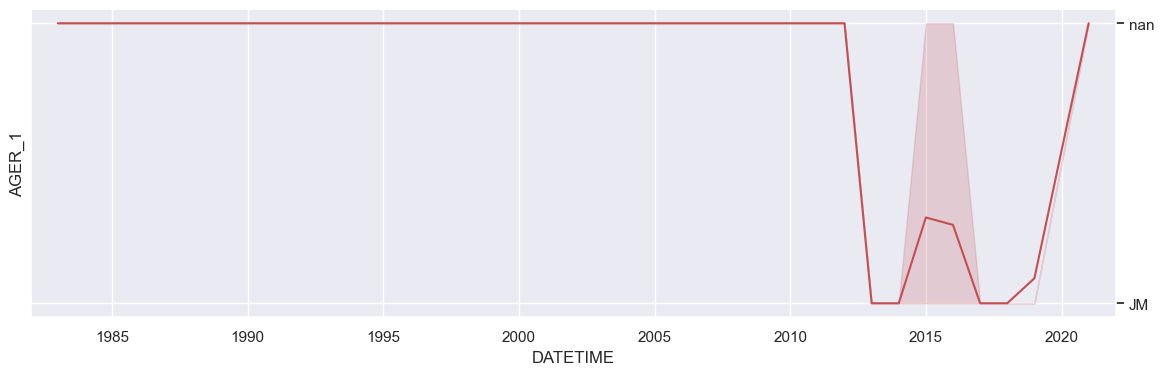


--------------------------------------------------
Data Info: AGE_1 

UNIQUE numbers, strings, blanks, null = (11, 0, 0, 1)
number of numeric = 31480
number of strings = 0
number of blanks = 0
number of null =  5432
check:  36912 == 36912

--------------------------------------------------
Histogram: AGE_1


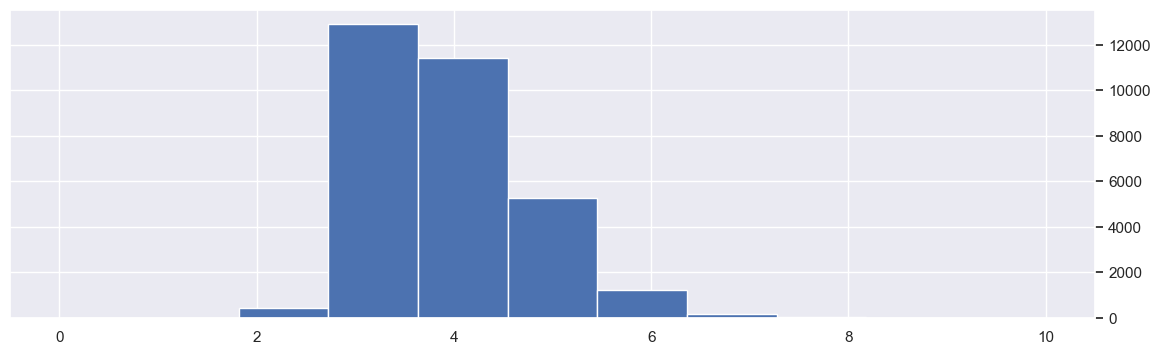


------------------------------------------------
Time Series:AGE_1
NUMERICAL


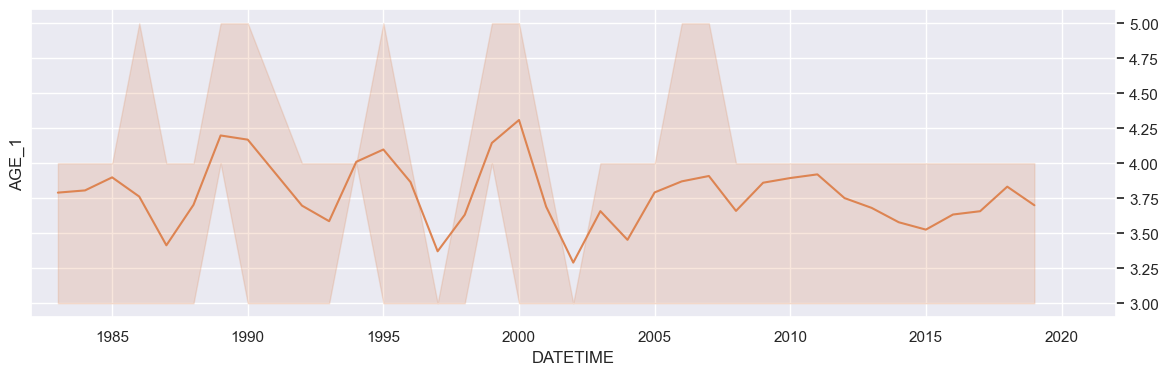


--------------------------------------------------
Data Info: FSP_1 

UNIQUE numbers, strings, blanks, null = (9, 0, 0, 1)
number of numeric = 31256
number of strings = 0
number of blanks = 0
number of null =  5656
check:  36912 == 36912

--------------------------------------------------
Histogram: FSP_1


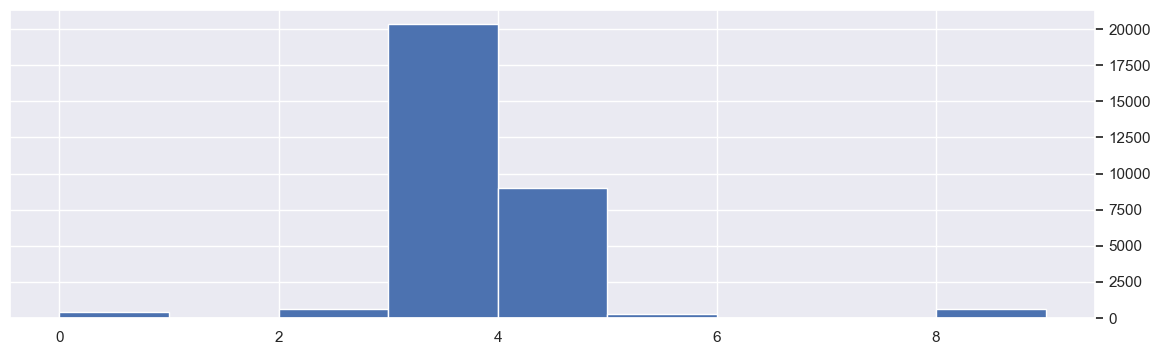


------------------------------------------------
Time Series:FSP_1
NUMERICAL


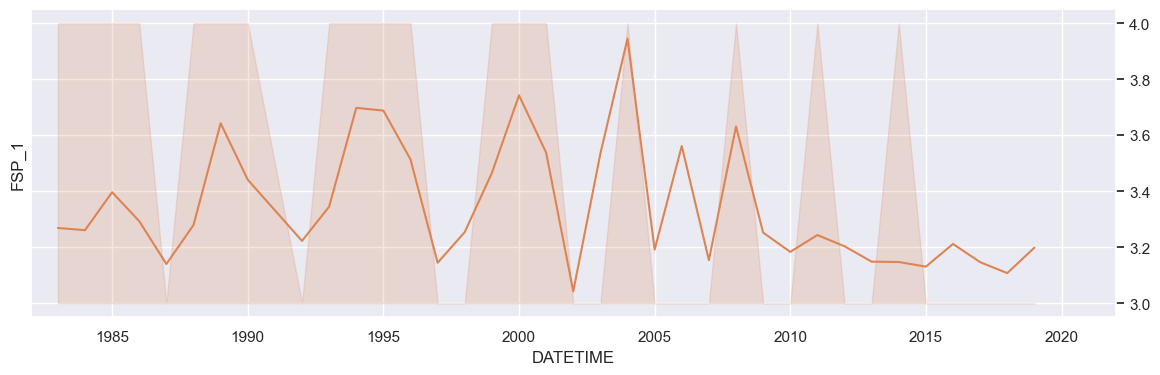


--------------------------------------------------
Data Info: AGER_2 

UNIQUE numbers, strings, blanks, null = (0, 1, 0, 1)
number of numeric = 0
number of strings = 1683
number of blanks = 0
number of null =  35229
check:  36912 == 36912

--------------------------------------------------
Histogram: AGER_2


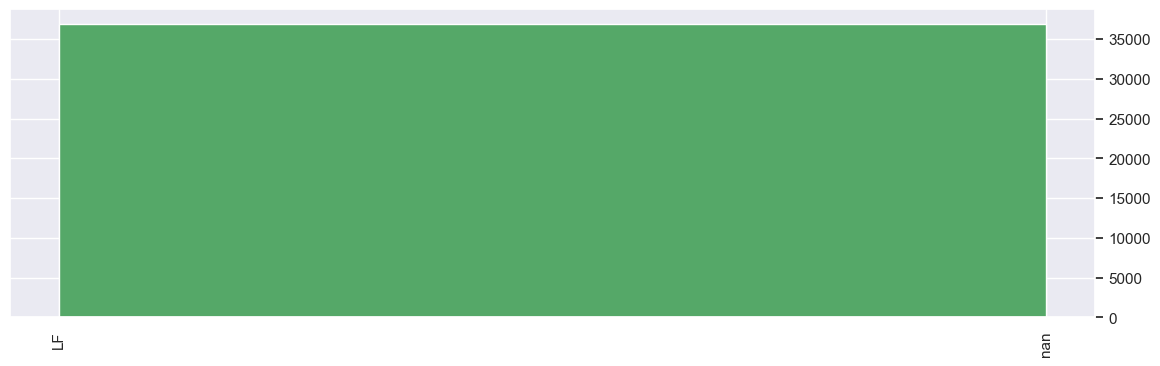


------------------------------------------------
Time Series:AGER_2
CATEGORICAL


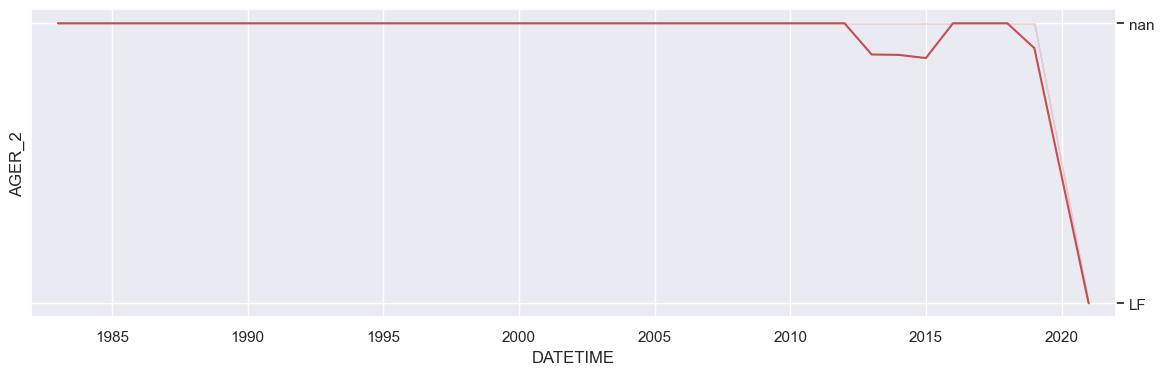


--------------------------------------------------
Data Info: AGE_2 

UNIQUE numbers, strings, blanks, null = (7, 0, 0, 1)
number of numeric = 1629
number of strings = 0
number of blanks = 0
number of null =  35283
check:  36912 == 36912

--------------------------------------------------
Histogram: AGE_2


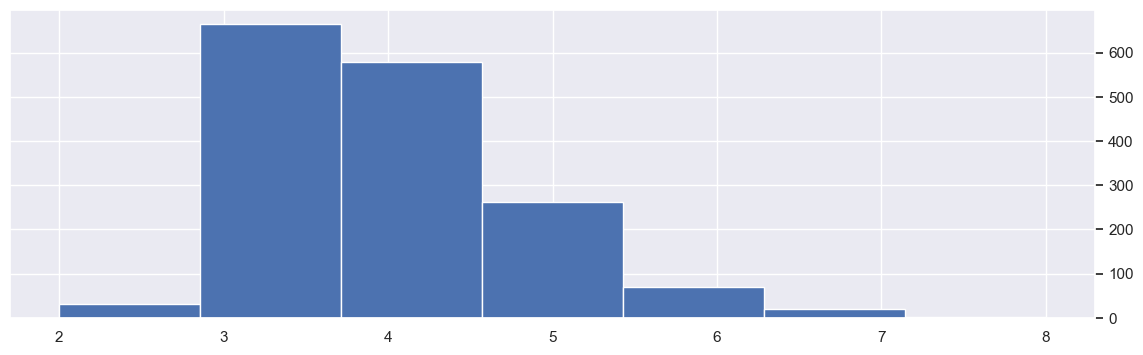


------------------------------------------------
Time Series:AGE_2
NUMERICAL


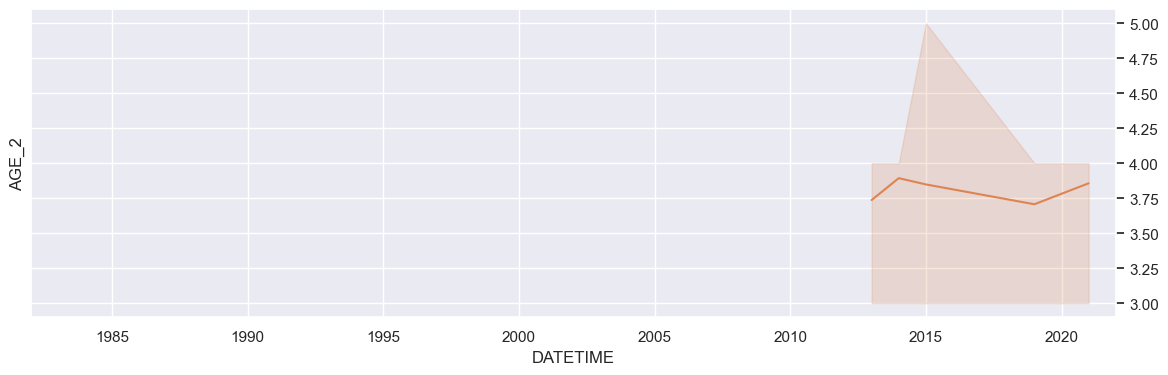


--------------------------------------------------
Data Info: FSP_2 

UNIQUE numbers, strings, blanks, null = (4, 0, 0, 1)
number of numeric = 1629
number of strings = 0
number of blanks = 0
number of null =  35283
check:  36912 == 36912

--------------------------------------------------
Histogram: FSP_2


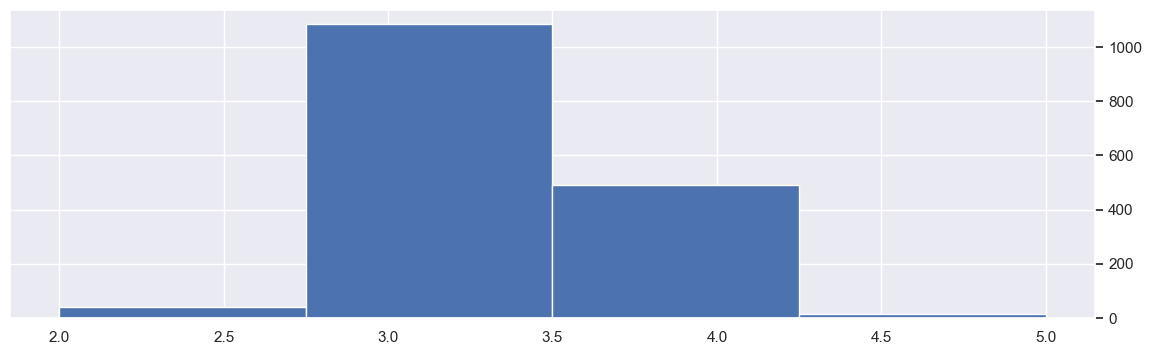


------------------------------------------------
Time Series:FSP_2
NUMERICAL


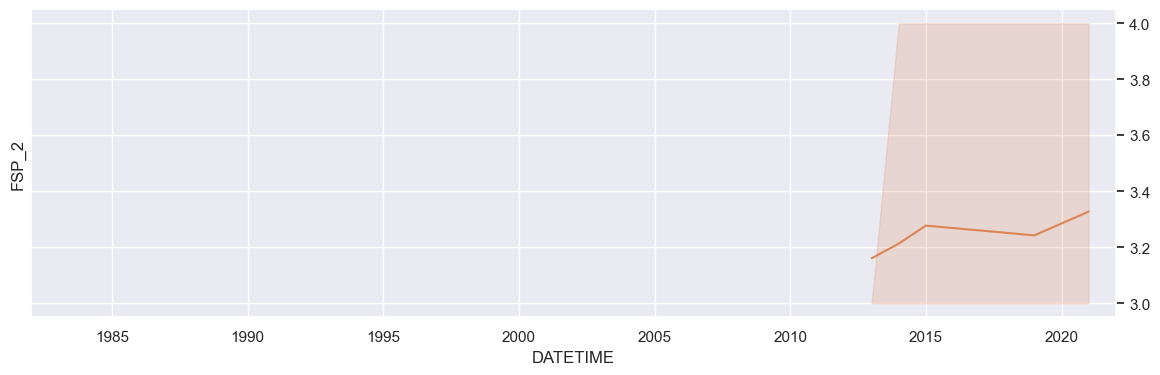


--------------------------------------------------
Data Info: AGER_3 

UNIQUE numbers, strings, blanks, null = (0, 1, 0, 1)
number of numeric = 0
number of strings = 2220
number of blanks = 0
number of null =  34692
check:  36912 == 36912

--------------------------------------------------
Histogram: AGER_3


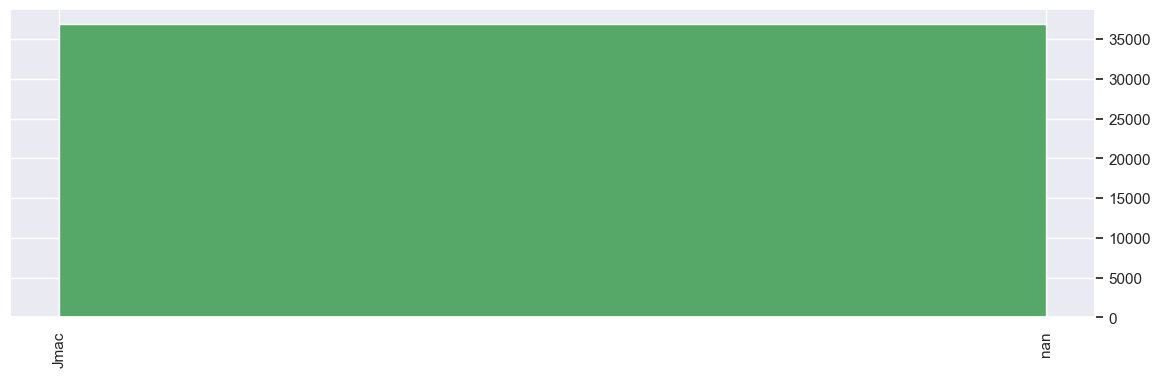


------------------------------------------------
Time Series:AGER_3
CATEGORICAL


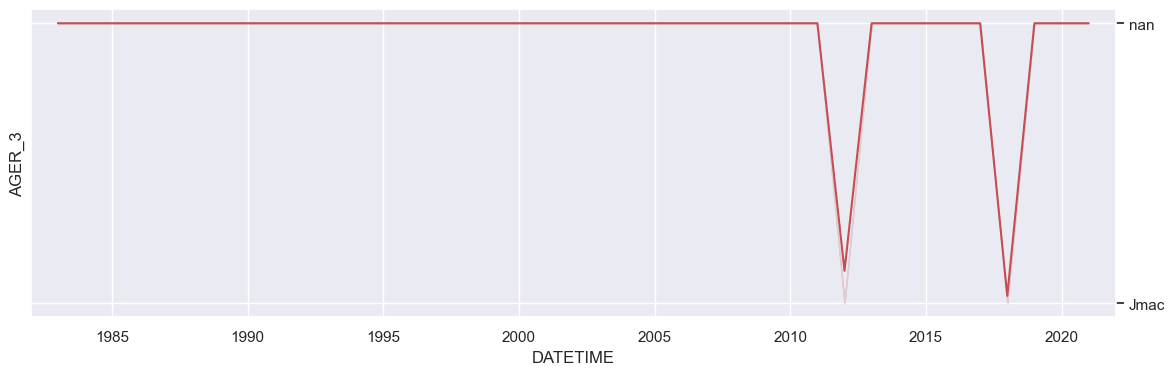


--------------------------------------------------
Data Info: AGE_3 

UNIQUE numbers, strings, blanks, null = (7, 0, 0, 1)
number of numeric = 2044
number of strings = 0
number of blanks = 0
number of null =  34868
check:  36912 == 36912

--------------------------------------------------
Histogram: AGE_3


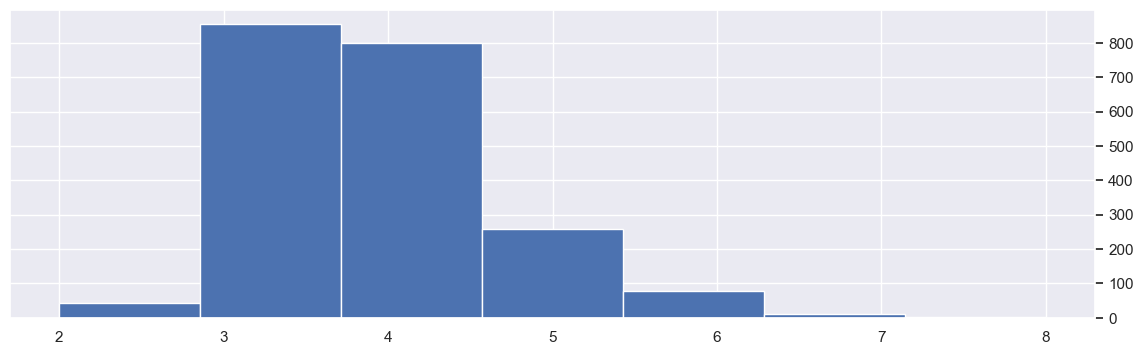


------------------------------------------------
Time Series:AGE_3
NUMERICAL


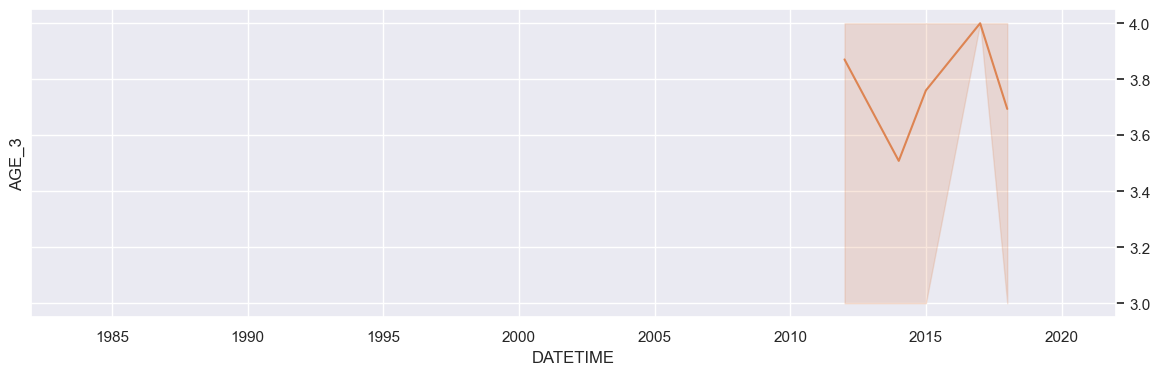


--------------------------------------------------
Data Info: FSP_3 

UNIQUE numbers, strings, blanks, null = (5, 0, 0, 1)
number of numeric = 2043
number of strings = 0
number of blanks = 0
number of null =  34869
check:  36912 == 36912

--------------------------------------------------
Histogram: FSP_3


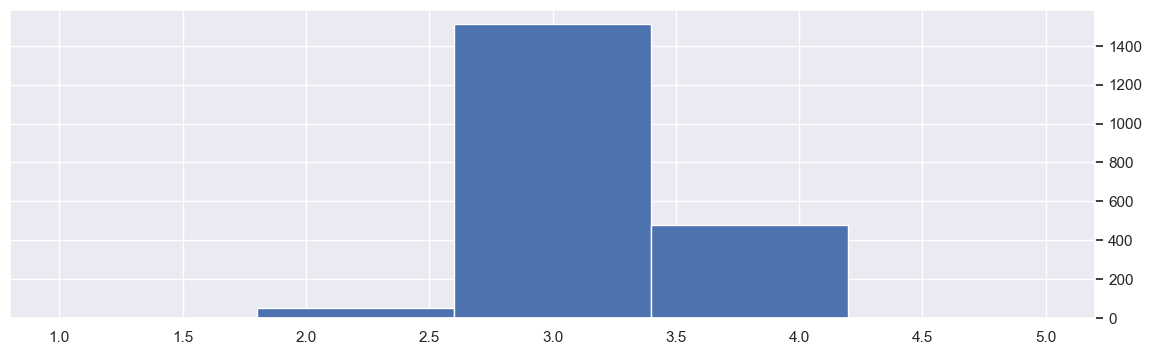


------------------------------------------------
Time Series:FSP_3
NUMERICAL


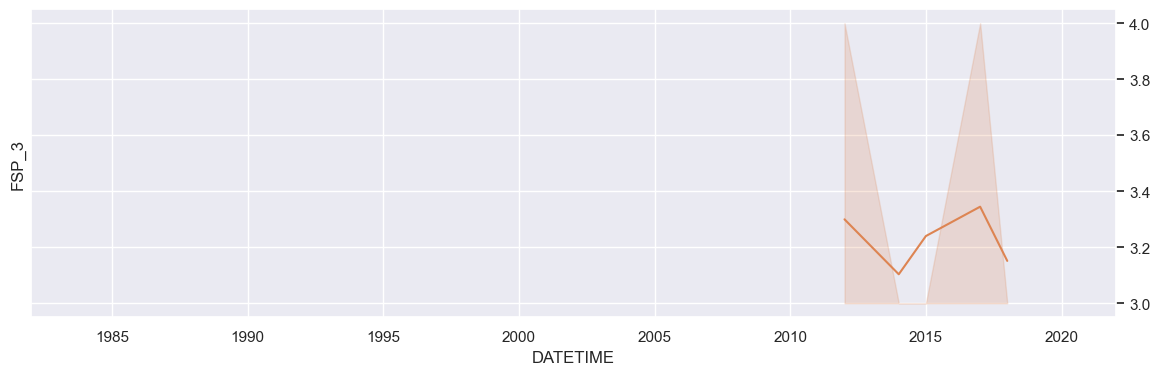

In [29]:
dont_plot_these_columns = [
    'sample_id', 'DATETIME', 
    'COMMENTS_1', 'COMMENTS_2', 'COMMENTS_3', 'ENVELOP_COMMENTS', 'remarks'
]

for col in [x for x in list(df_FD.columns) if x not in dont_plot_these_columns]:
    do_EDA_stuff(df_FD, col)

### SAMPLES

In [30]:
df_SD.columns

Index(['sample_id', 'sample_date', 'district_id', 'RIVER', 'SAMPLER', 'CODE',
       'gear_id', 'SITE', 'NO_NETS', 'catch_weight_lbs', 'HOURS_FISHED',
       'ZONE', 'LAST_NAME', 'COMMENTS', 'BYCATCH_SBASS', 'BYCATCH_SHAD',
       'BYCATCH_OTHER', 'remarks', 'total_fish_preserved',
       'total_fish_measured', 'sample_weight_lbs'],
      dtype='object')

In [31]:
# can't plot CODE, has no non-null numbers
df_SD.CODE.unique()

array([nan], dtype=object)


--------------------------------------------------
Data Info: DISTRICT_ID 

UNIQUE numbers, strings, blanks, null = (1, 0, 0, 0)
number of numeric = 15213
number of strings = 0
number of blanks = 0
number of null =  0
check:  15213 == 15213

--------------------------------------------------
Histogram: DISTRICT_ID


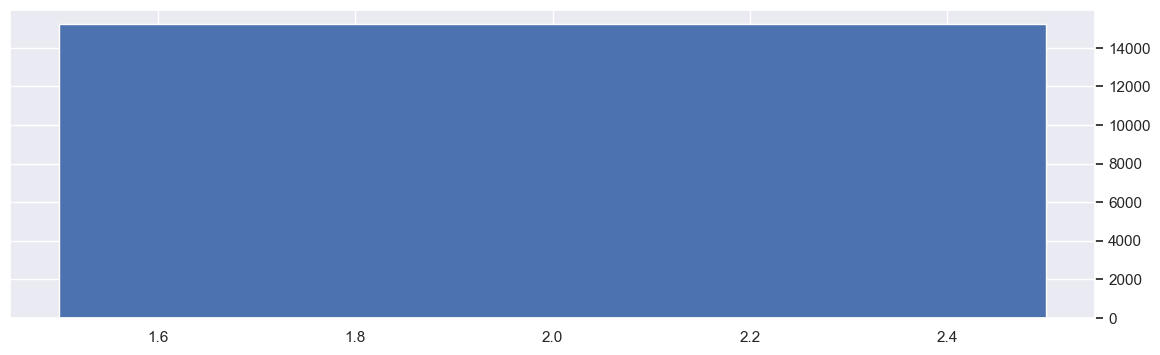


------------------------------------------------
Time Series:DISTRICT_ID
NUMERICAL


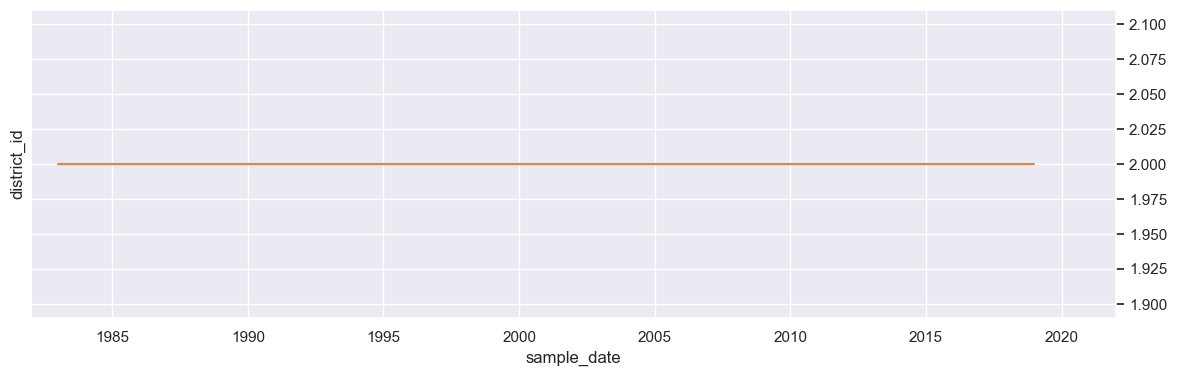


--------------------------------------------------
Data Info: RIVER 

UNIQUE numbers, strings, blanks, null = (0, 1, 0, 0)
number of numeric = 0
number of strings = 15213
number of blanks = 0
number of null =  0
check:  15213 == 15213

--------------------------------------------------
Histogram: RIVER


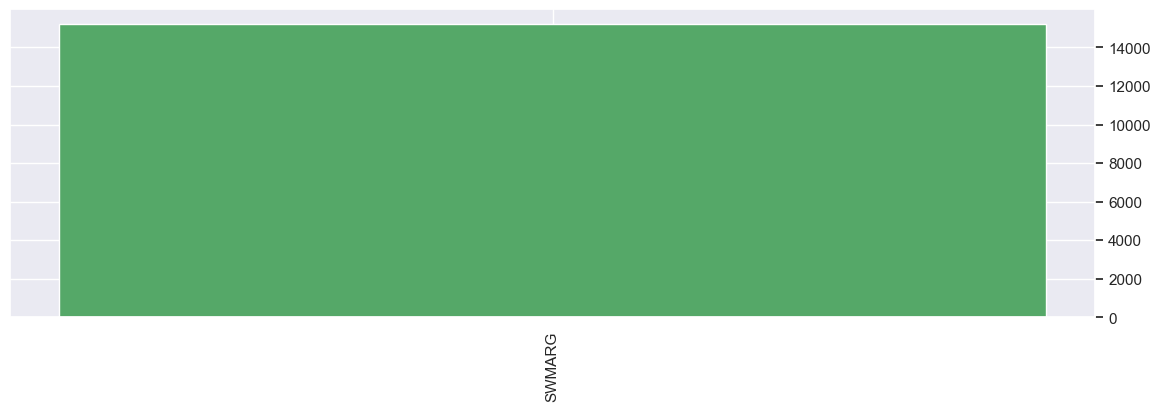


------------------------------------------------
Time Series:RIVER
CATEGORICAL


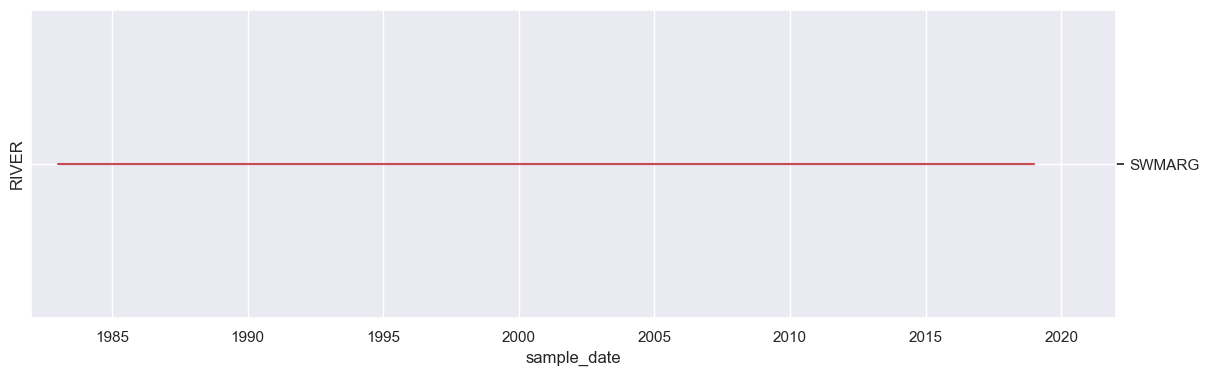


--------------------------------------------------
Data Info: SAMPLER 

UNIQUE numbers, strings, blanks, null = (0, 74, 0, 0)
number of numeric = 0
number of strings = 15213
number of blanks = 0
number of null =  0
check:  15213 == 15213

--------------------------------------------------
Histogram: SAMPLER


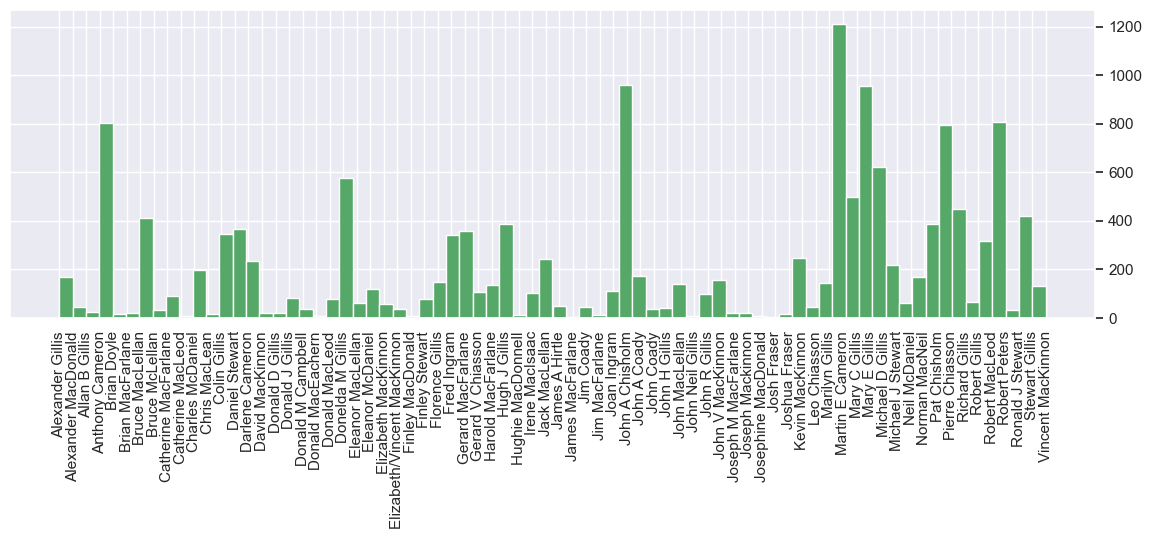


------------------------------------------------
Time Series:SAMPLER
CATEGORICAL


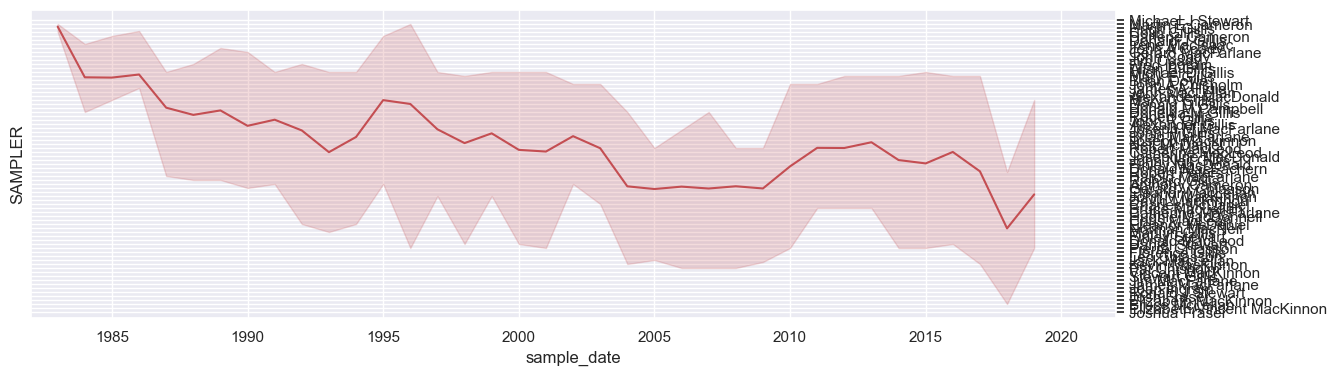


--------------------------------------------------
Data Info: GEAR_ID 

UNIQUE numbers, strings, blanks, null = (1, 0, 0, 0)
number of numeric = 15213
number of strings = 0
number of blanks = 0
number of null =  0
check:  15213 == 15213

--------------------------------------------------
Histogram: GEAR_ID


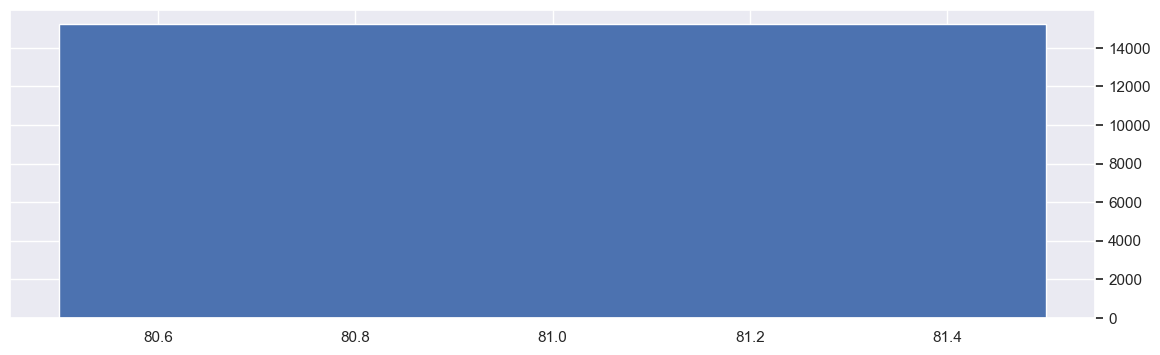


------------------------------------------------
Time Series:GEAR_ID
NUMERICAL


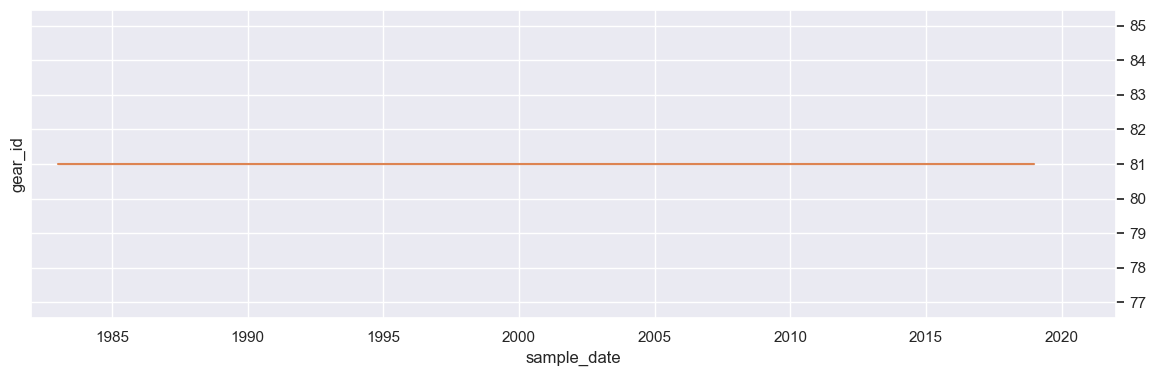


--------------------------------------------------
Data Info: SITE 

UNIQUE numbers, strings, blanks, null = (61, 0, 0, 0)
number of numeric = 15213
number of strings = 0
number of blanks = 0
number of null =  0
check:  15213 == 15213

--------------------------------------------------
Histogram: SITE


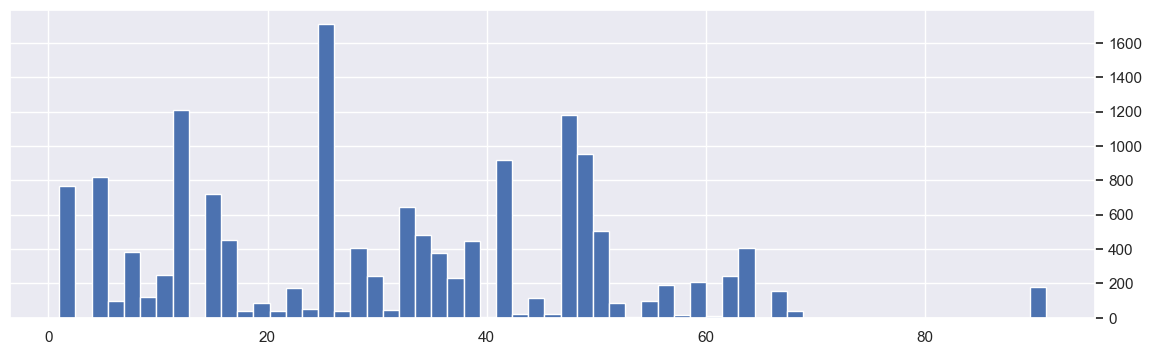


------------------------------------------------
Time Series:SITE
NUMERICAL


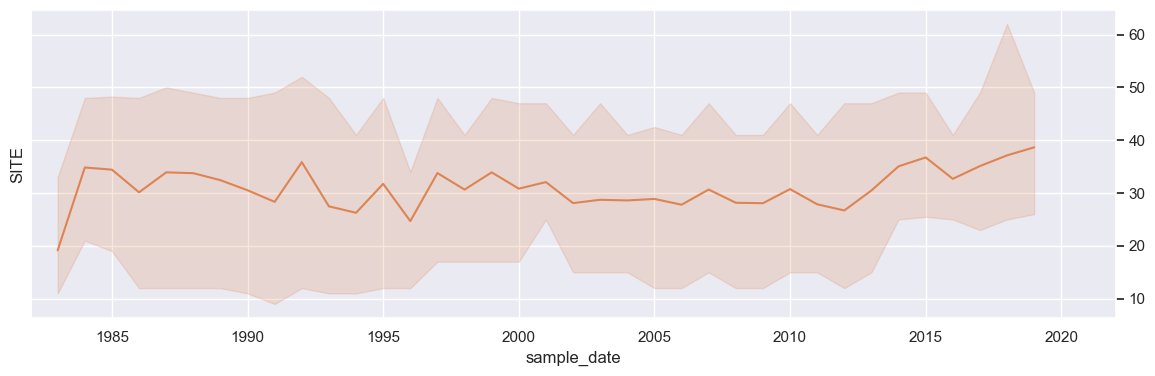


--------------------------------------------------
Data Info: NO_NETS 

UNIQUE numbers, strings, blanks, null = (2, 0, 0, 1)
number of numeric = 9623
number of strings = 0
number of blanks = 0
number of null =  5590
check:  15213 == 15213

--------------------------------------------------
Histogram: NO_NETS


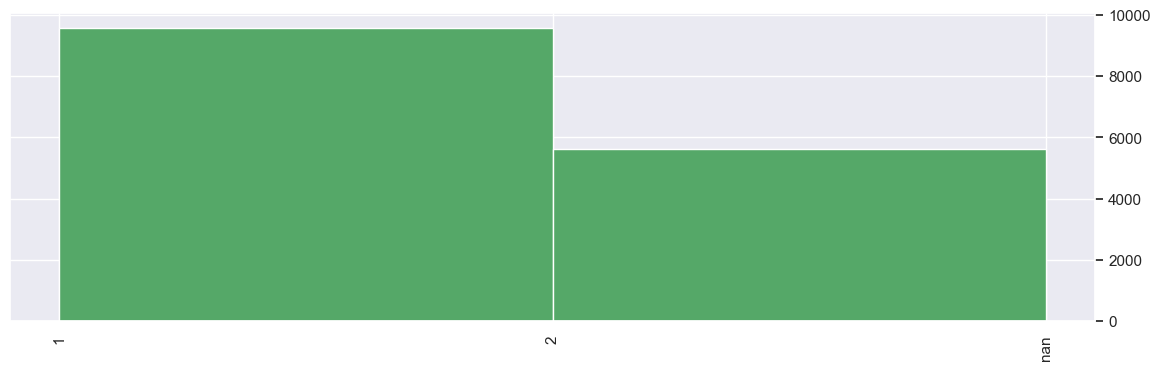


------------------------------------------------
Time Series:NO_NETS
NUMERICAL


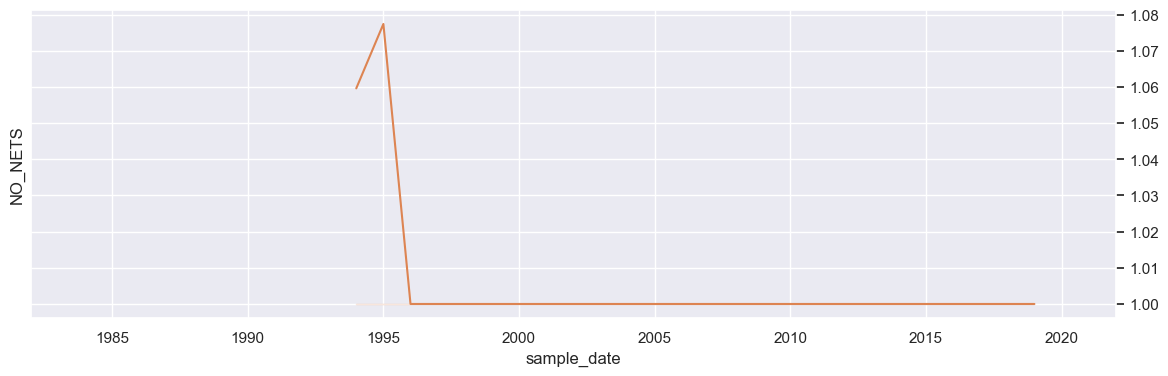


--------------------------------------------------
Data Info: CATCH_WEIGHT_LBS 

UNIQUE numbers, strings, blanks, null = (689, 0, 0, 1)
number of numeric = 15200
number of strings = 0
number of blanks = 0
number of null =  13
check:  15213 == 15213

--------------------------------------------------
Histogram: CATCH_WEIGHT_LBS


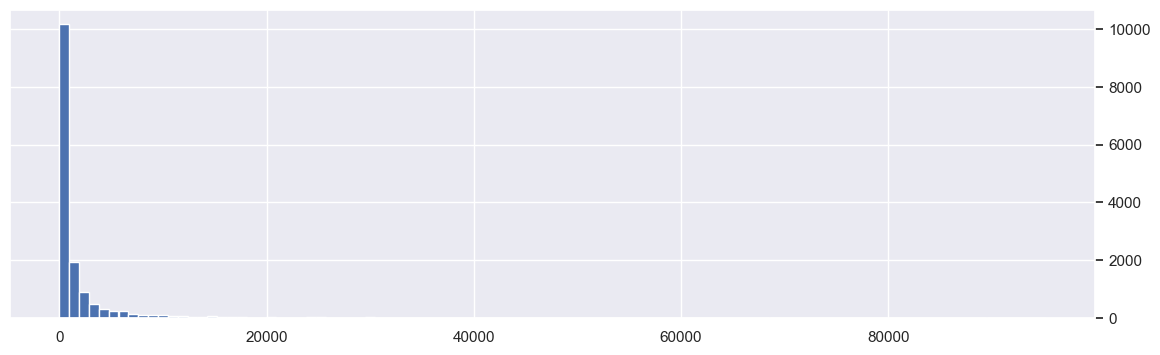


------------------------------------------------
Time Series:CATCH_WEIGHT_LBS
NUMERICAL


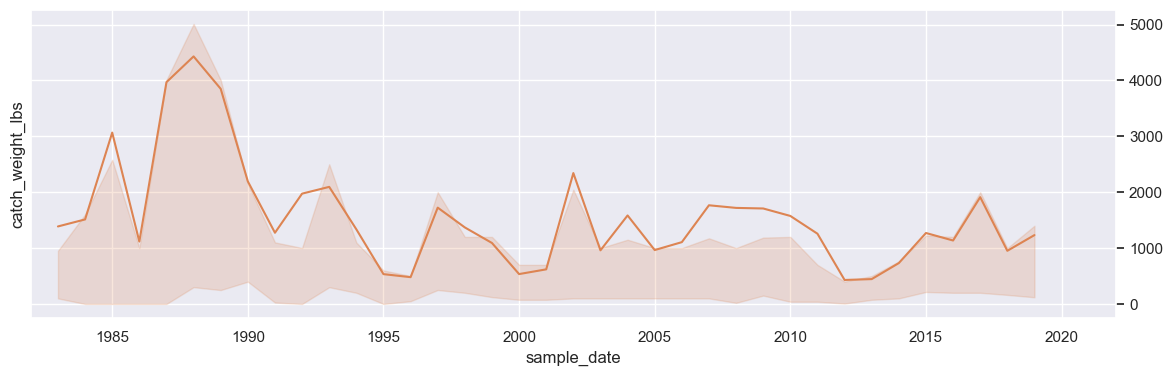


--------------------------------------------------
Data Info: HOURS_FISHED 

UNIQUE numbers, strings, blanks, null = (38, 0, 0, 1)
number of numeric = 13534
number of strings = 0
number of blanks = 0
number of null =  1679
check:  15213 == 15213

--------------------------------------------------
Histogram: HOURS_FISHED


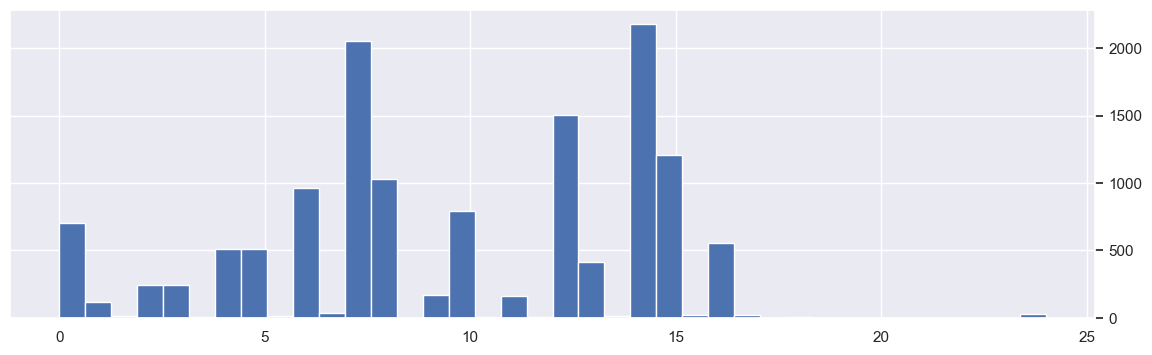


------------------------------------------------
Time Series:HOURS_FISHED
NUMERICAL


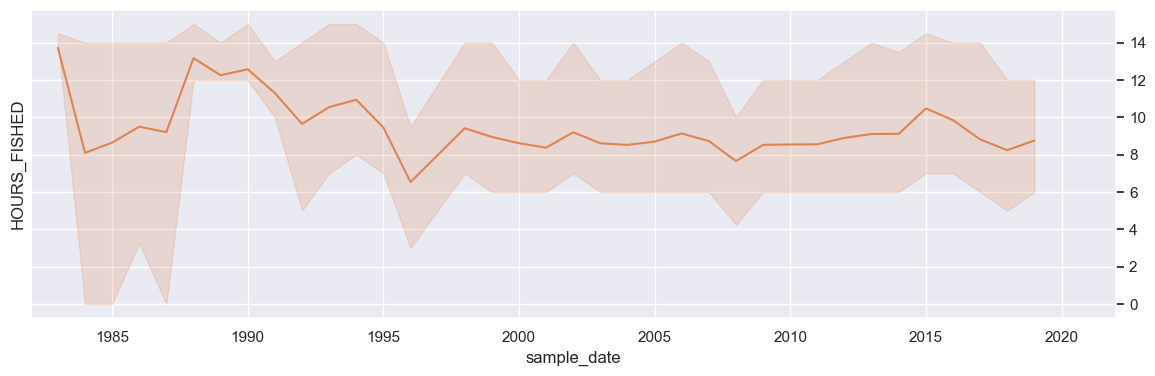


--------------------------------------------------
Data Info: ZONE 

UNIQUE numbers, strings, blanks, null = (0, 2, 0, 1)
number of numeric = 0
number of strings = 15208
number of blanks = 0
number of null =  5
check:  15213 == 15213

--------------------------------------------------
Histogram: ZONE


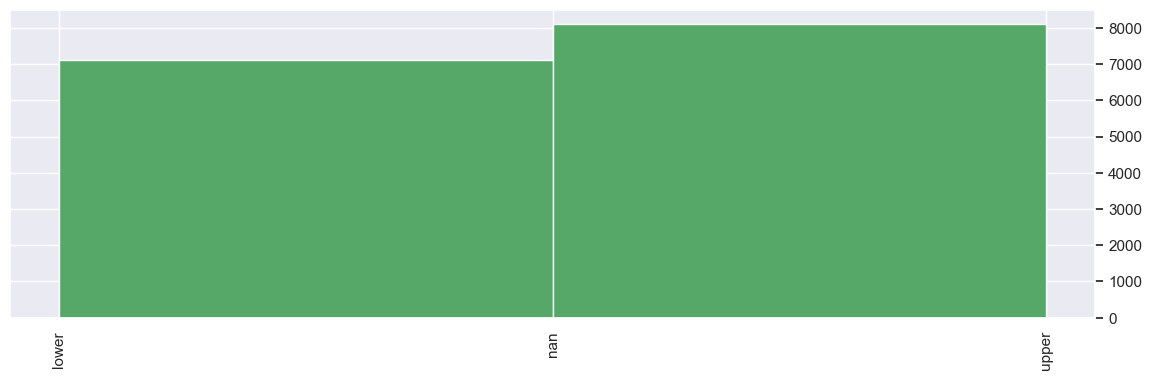


------------------------------------------------
Time Series:ZONE
CATEGORICAL


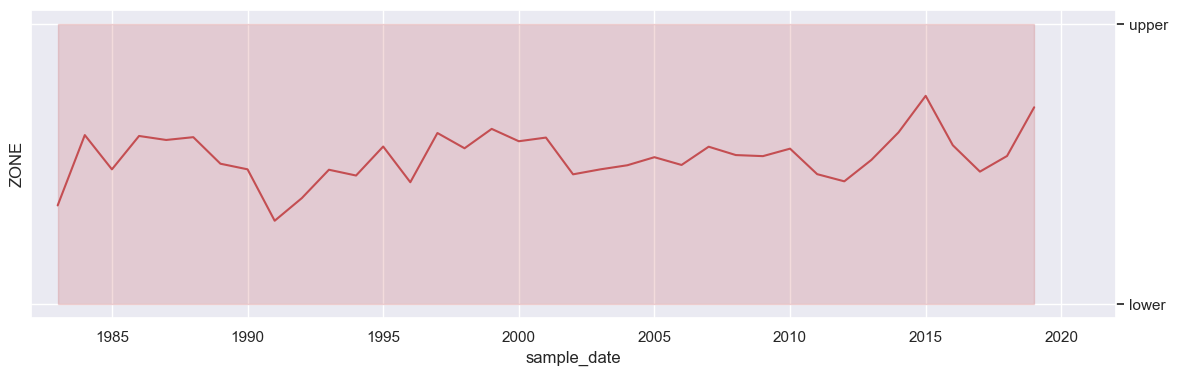


--------------------------------------------------
Data Info: LAST_NAME 

UNIQUE numbers, strings, blanks, null = (0, 30, 0, 1)
number of numeric = 0
number of strings = 13582
number of blanks = 0
number of null =  1631
check:  15213 == 15213

--------------------------------------------------
Histogram: LAST_NAME


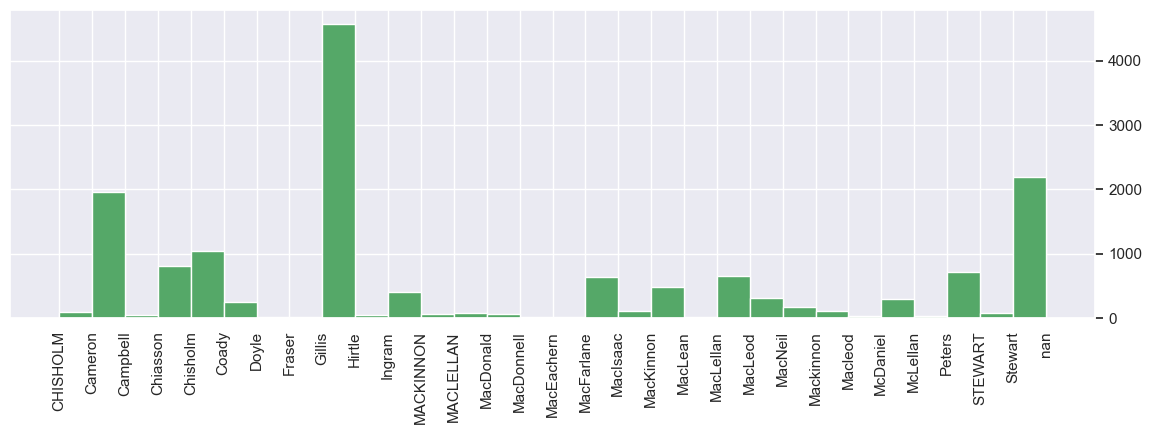


------------------------------------------------
Time Series:LAST_NAME
CATEGORICAL


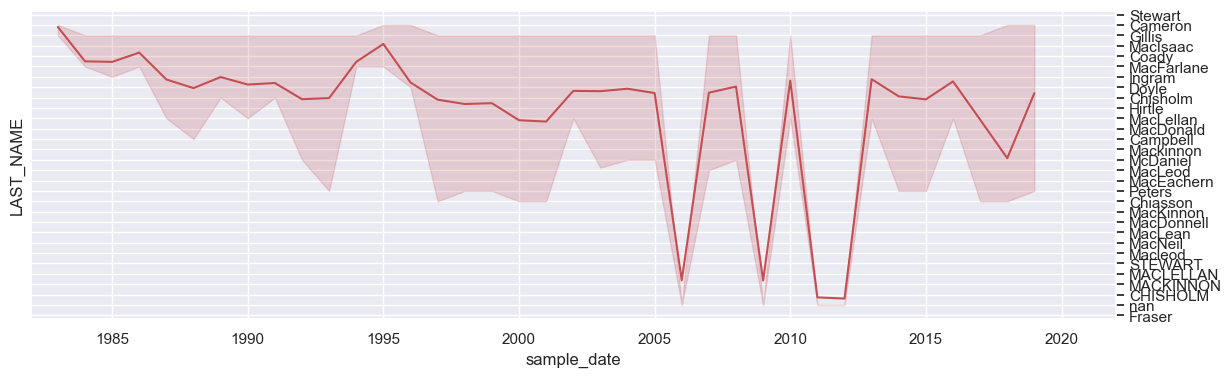


--------------------------------------------------
Data Info: BYCATCH_SBASS 

UNIQUE numbers, strings, blanks, null = (3, 0, 0, 1)
number of numeric = 18
number of strings = 0
number of blanks = 0
number of null =  15195
check:  15213 == 15213

--------------------------------------------------
Histogram: BYCATCH_SBASS


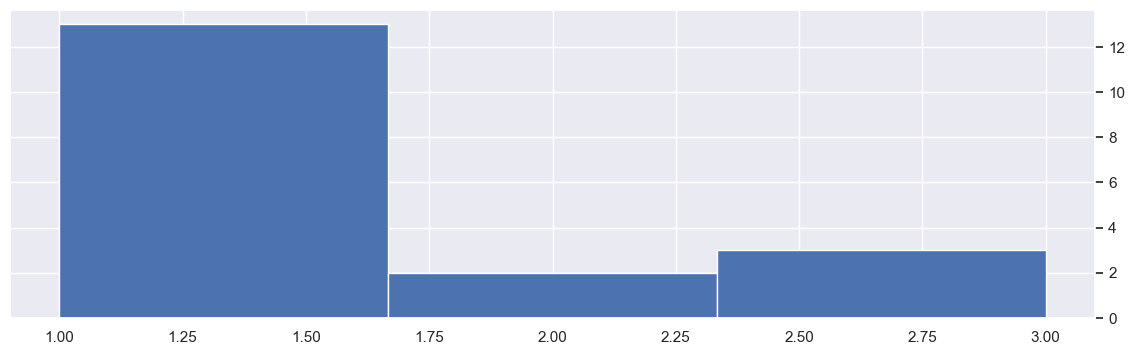


------------------------------------------------
Time Series:BYCATCH_SBASS
NUMERICAL


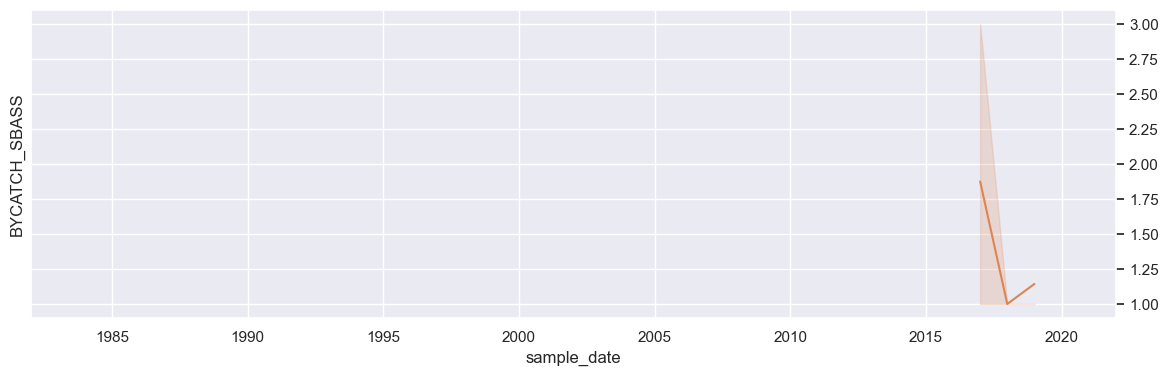


--------------------------------------------------
Data Info: BYCATCH_SHAD 

UNIQUE numbers, strings, blanks, null = (1, 0, 0, 1)
number of numeric = 4
number of strings = 0
number of blanks = 0
number of null =  15209
check:  15213 == 15213

--------------------------------------------------
Histogram: BYCATCH_SHAD


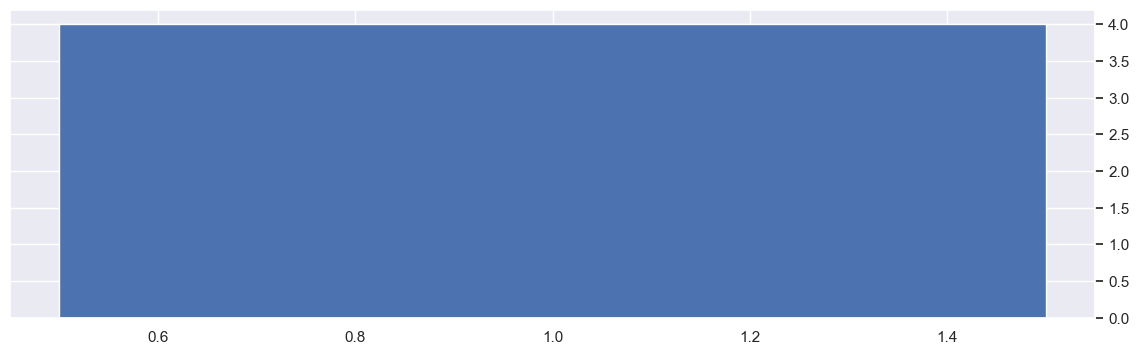


------------------------------------------------
Time Series:BYCATCH_SHAD
NUMERICAL


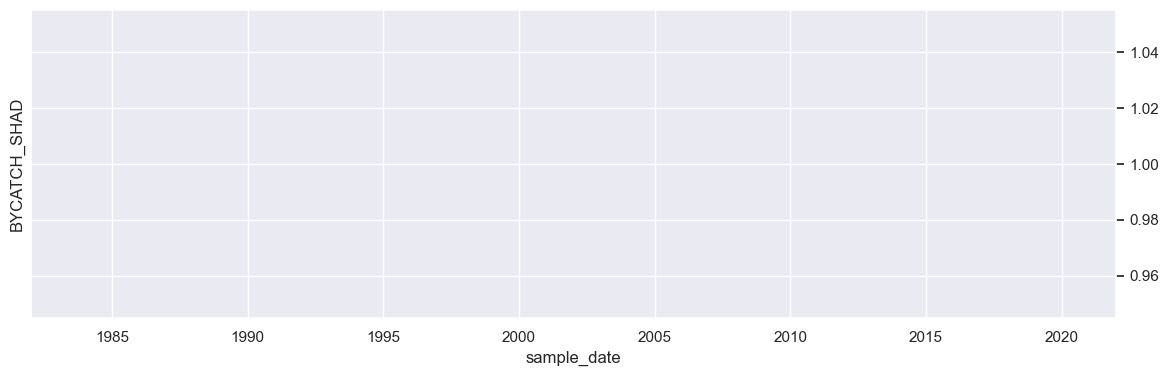


--------------------------------------------------
Data Info: BYCATCH_OTHER 

UNIQUE numbers, strings, blanks, null = (1, 12, 0, 1)
number of numeric = 5
number of strings = 13
number of blanks = 0
number of null =  15195
check:  15213 == 15213

--------------------------------------------------
Histogram: BYCATCH_OTHER


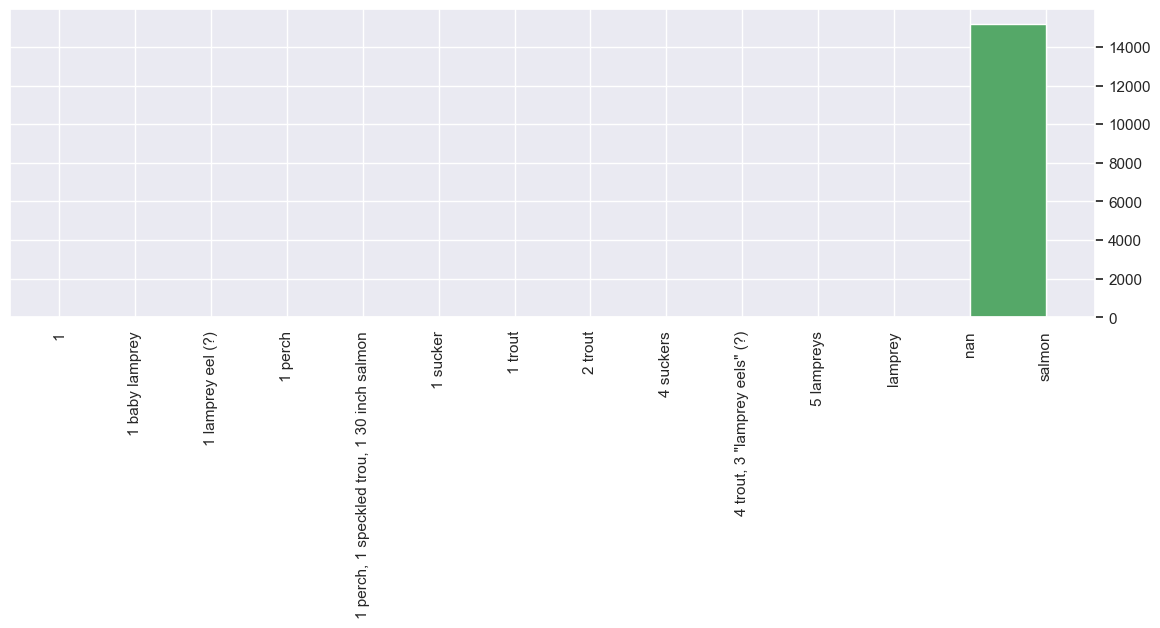


------------------------------------------------
Time Series:BYCATCH_OTHER
CATEGORICAL


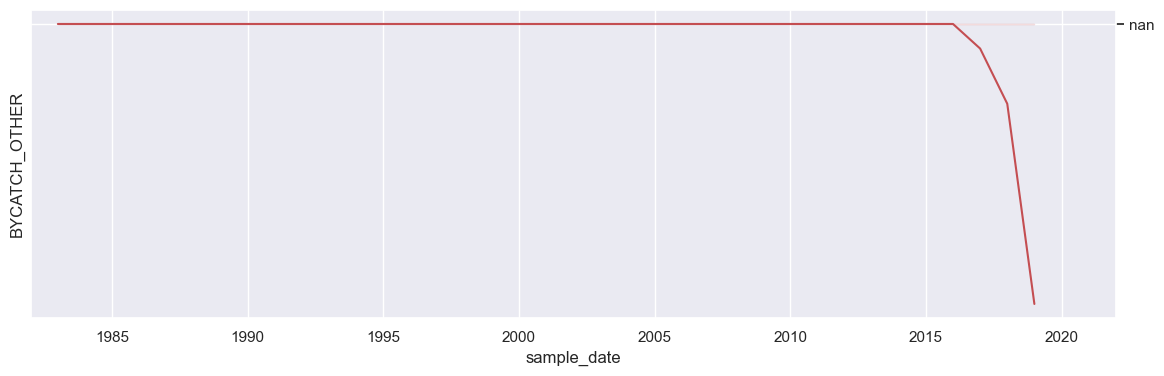


--------------------------------------------------
Data Info: TOTAL_FISH_PRESERVED 

UNIQUE numbers, strings, blanks, null = (50, 0, 0, 1)
number of numeric = 908
number of strings = 0
number of blanks = 0
number of null =  14305
check:  15213 == 15213

--------------------------------------------------
Histogram: TOTAL_FISH_PRESERVED


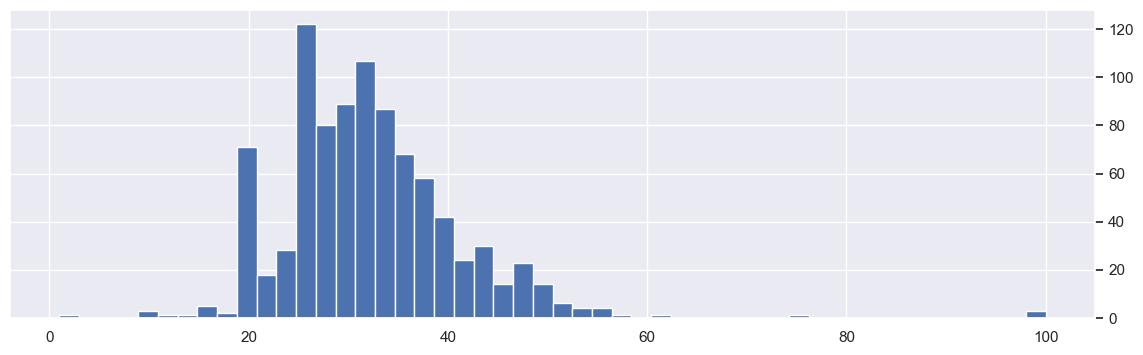


------------------------------------------------
Time Series:TOTAL_FISH_PRESERVED
NUMERICAL


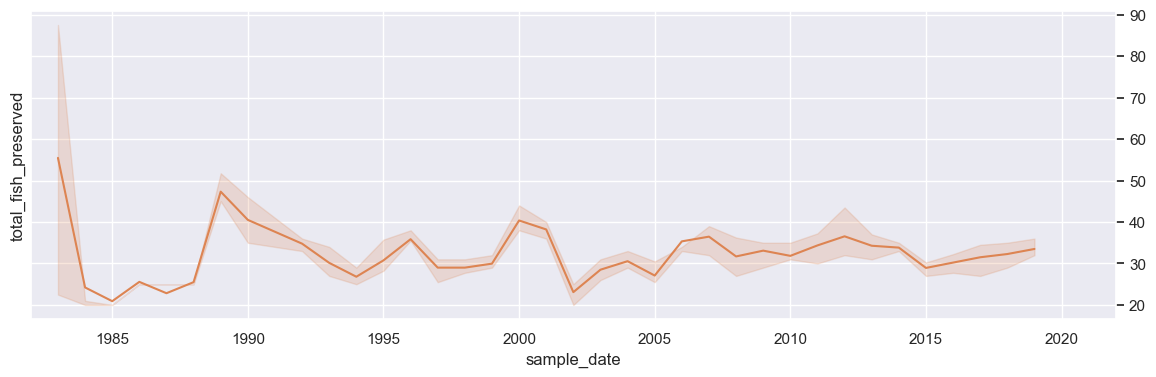


--------------------------------------------------
Data Info: TOTAL_FISH_MEASURED 

UNIQUE numbers, strings, blanks, null = (249, 0, 0, 1)
number of numeric = 731
number of strings = 0
number of blanks = 0
number of null =  14482
check:  15213 == 15213

--------------------------------------------------
Histogram: TOTAL_FISH_MEASURED


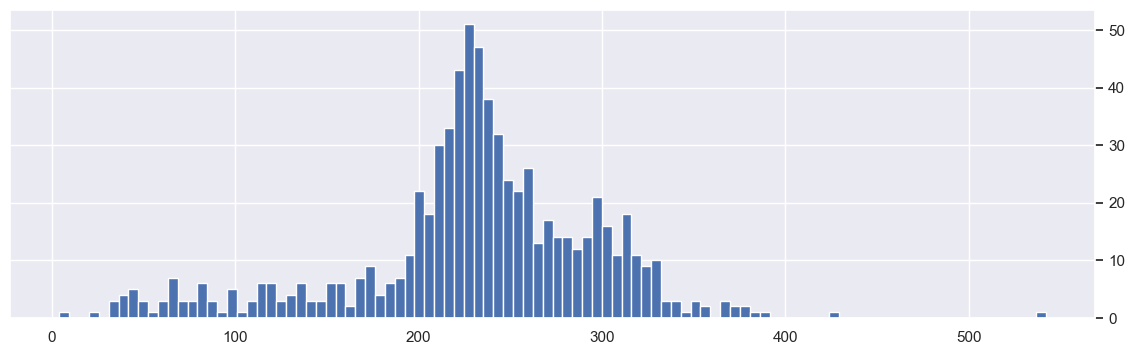


------------------------------------------------
Time Series:TOTAL_FISH_MEASURED
NUMERICAL


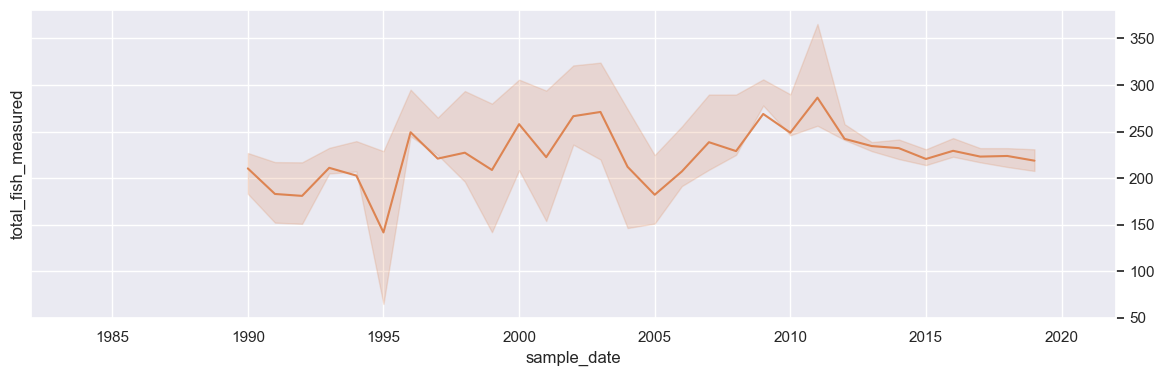


--------------------------------------------------
Data Info: SAMPLE_WEIGHT_LBS 

UNIQUE numbers, strings, blanks, null = (215, 0, 0, 1)
number of numeric = 680
number of strings = 0
number of blanks = 0
number of null =  14533
check:  15213 == 15213

--------------------------------------------------
Histogram: SAMPLE_WEIGHT_LBS


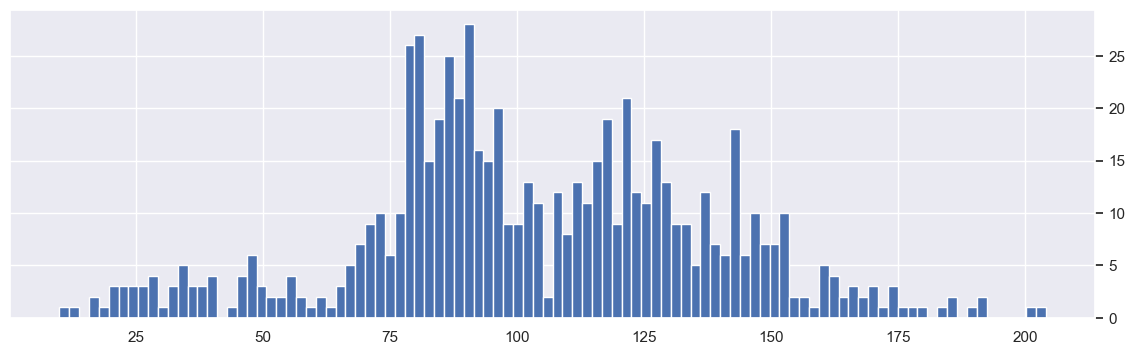


------------------------------------------------
Time Series:SAMPLE_WEIGHT_LBS
NUMERICAL


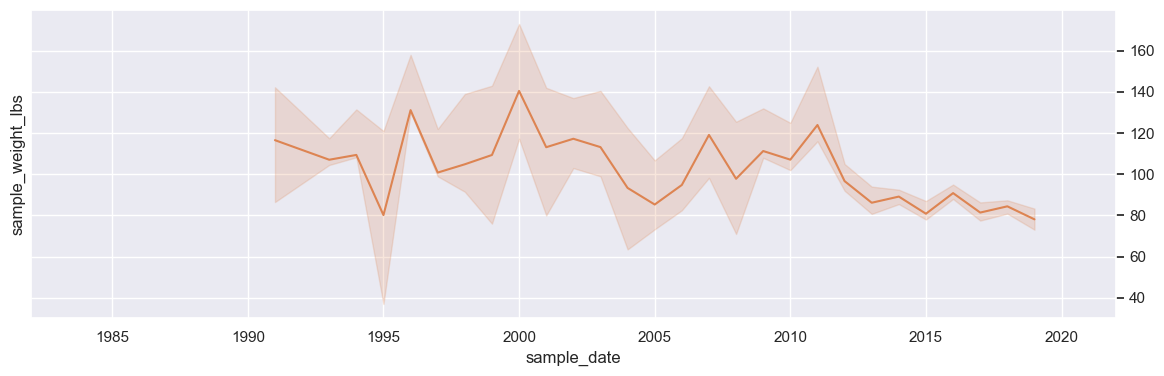

In [32]:
dont_plot_these_columns = [
    'sample_id', 'sample_date', 'COMMENTS', 'remarks', 'CODE'
]

for col in [x for x in list(df_SD.columns) if x not in dont_plot_these_columns]:
    do_EDA_stuff(df_SD, col, 'sample_date')

### LENGTH FREQUENCY

linear colour map


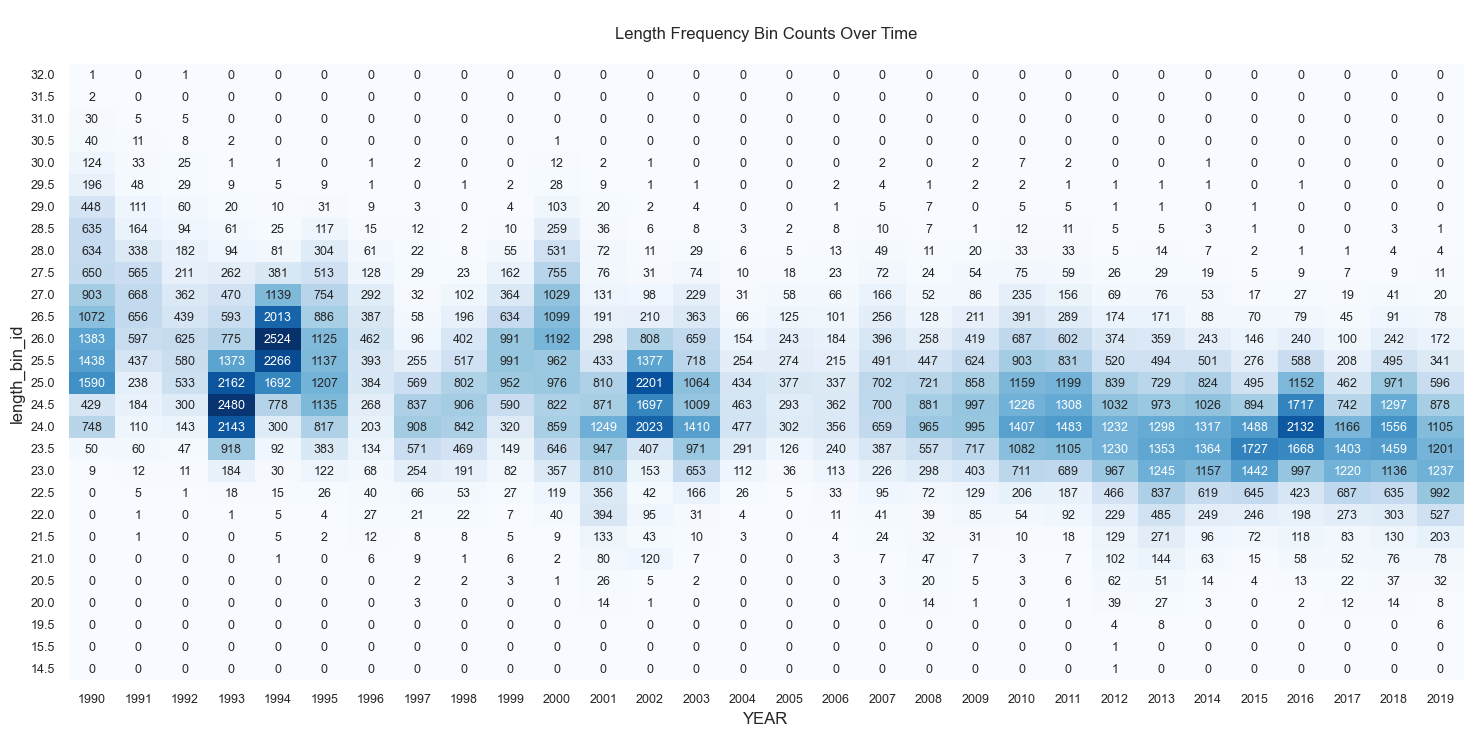

log normal colour map


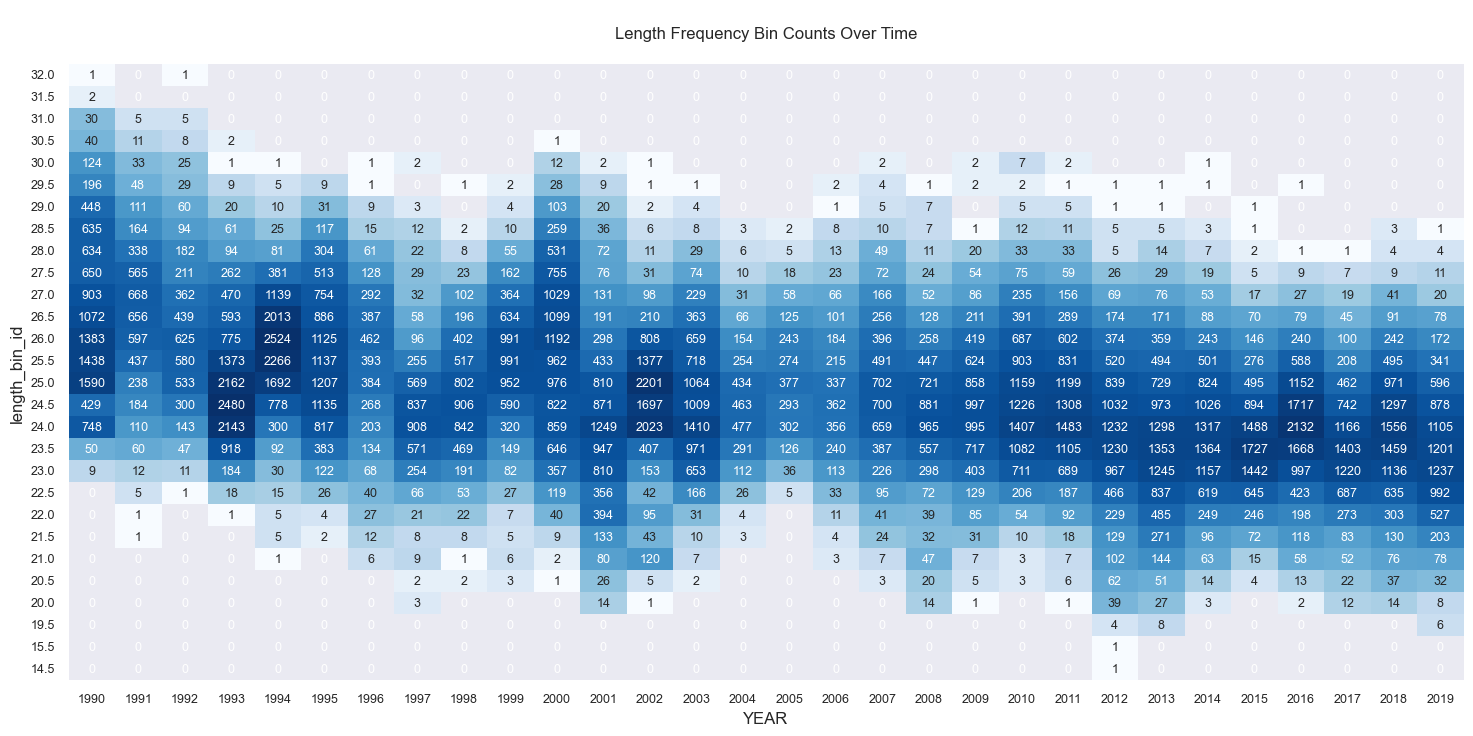

In [33]:
# HEATMAP for timeseries

TEMP = df_LF.copy()
TEMP['YEAR'] = df_LF.sample_id//1000000
TEMP = TEMP.drop('sample_id', axis=1)
TEMP = TEMP[TEMP.YEAR < 2023]

TEMP = TEMP.groupby(['YEAR', 'length_bin_id']).sum().reset_index(level=1)

def print_heatmap(**kwargs):
    fontsize=9

    # plot the grouped series
    plt.figure(figsize=(18, 8))

    plot = sns.heatmap(
        TEMP.reset_index().pivot('length_bin_id', 'YEAR', 'count').sort_values('length_bin_id', ascending=False).fillna(0),
        annot=True, 
        annot_kws={'size':fontsize},
        fmt='.0f',
        cbar=False,
        cmap='Blues',
        **kwargs
    )
    plt.title('\nLength Frequency Bin Counts Over Time\n')
    plot.tick_params(axis='both', which='major', labelsize=fontsize)

    plt.show()
    

# two different versions of the data viz (log normal and linear scale colour map)
print('=============================================')
print('linear colour map')
print_heatmap()
print('=============================================')
print('log normal colour map')
print_heatmap(norm=LogNorm())

----------------------------------------------
Histogram: 2011051741


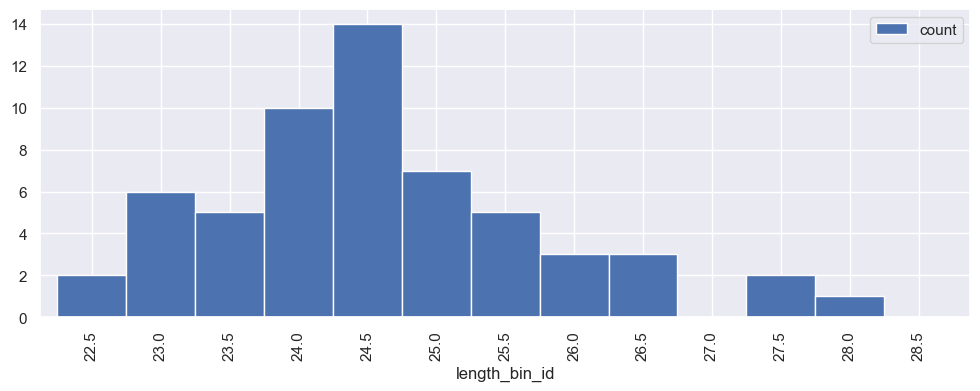

----------------------------------------------
Histogram: 1994052741


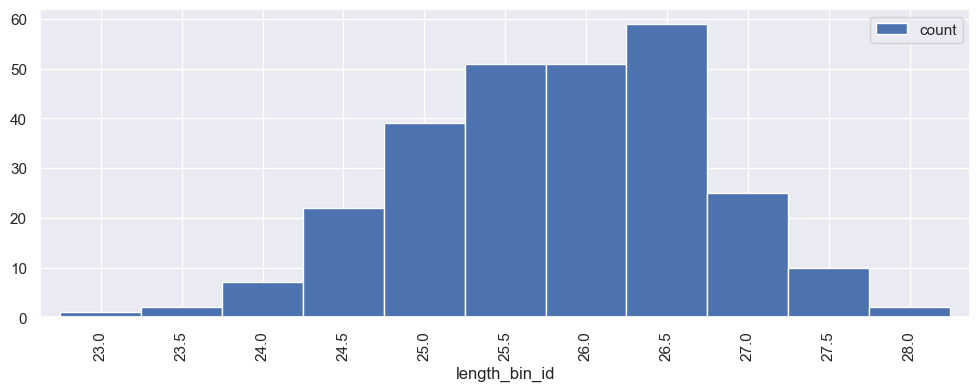

----------------------------------------------
Histogram: 2008052705


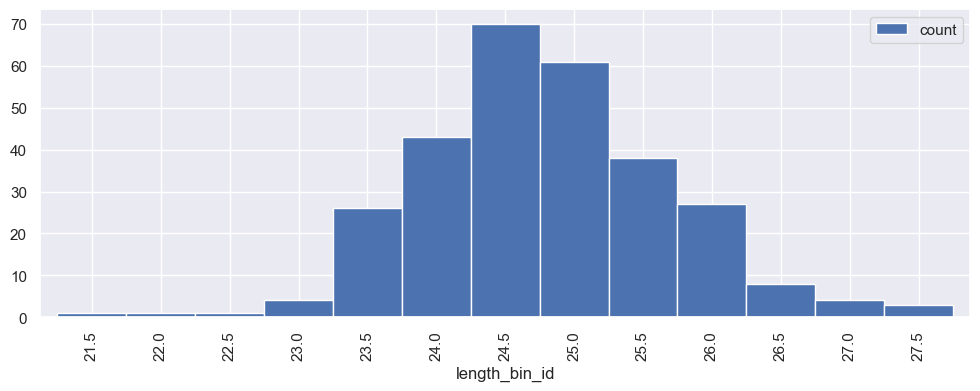

----------------------------------------------
Histogram: 1990050805


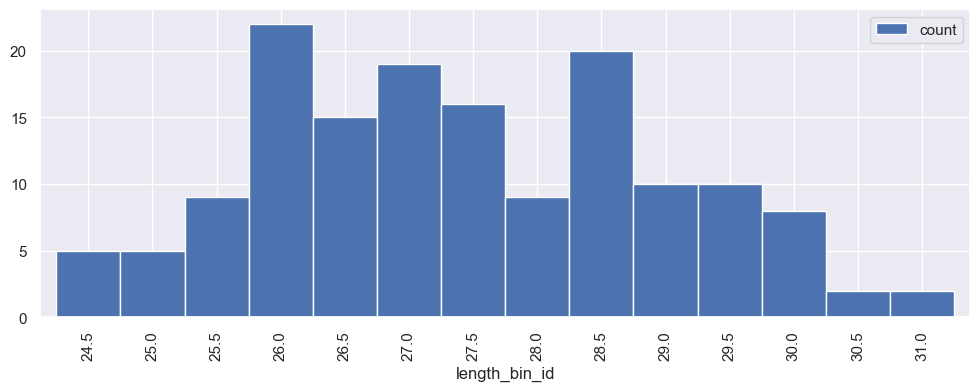

----------------------------------------------
Histogram: 2017052026


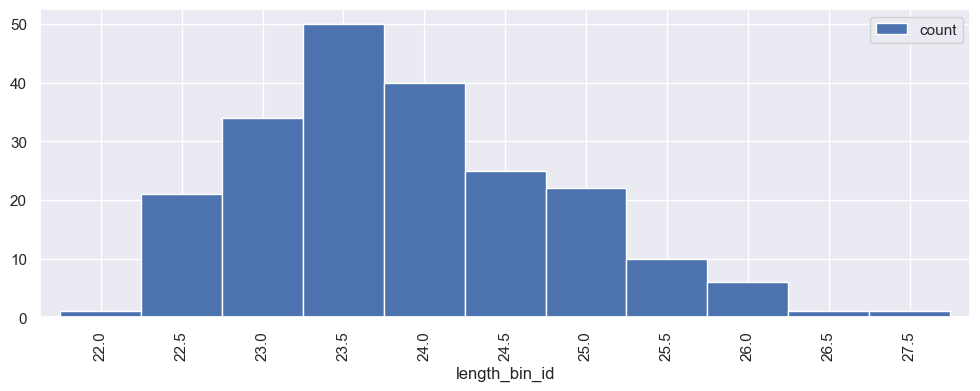

In [34]:
# check a few histograms from random samples
for i in range(5):
    sample_id = np.random.choice(df_LF.sample_id.unique())
    print('----------------------------------------------\nHistogram:', sample_id)
    df_LF.loc[df_LF.sample_id==sample_id, ['count', 'length_bin_id']].plot(
        kind='bar', x='length_bin_id', y='count', width=1, figsize=(12,4)
    )
    plt.show()

### Still Unanswered Questions from the Visualisations
* fish details: why did maturity distributions change in the 90s?
* more questions?

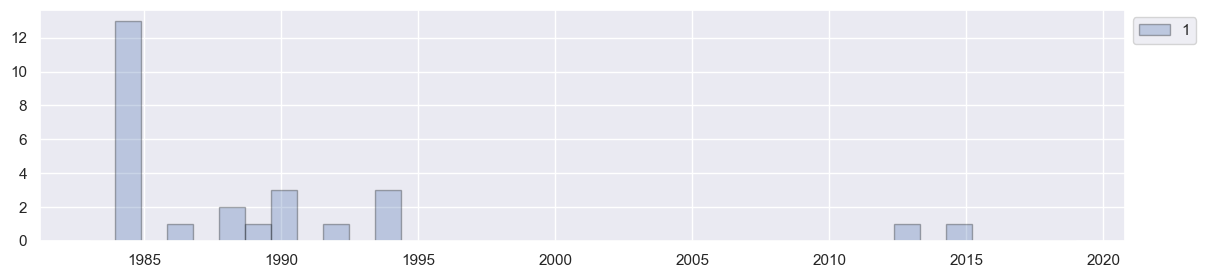

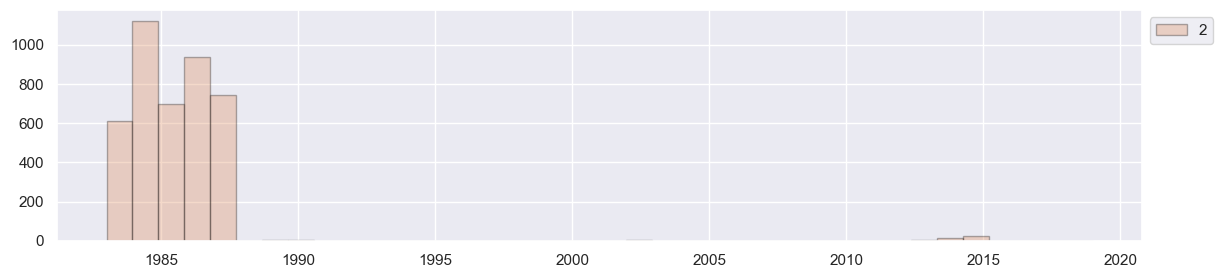

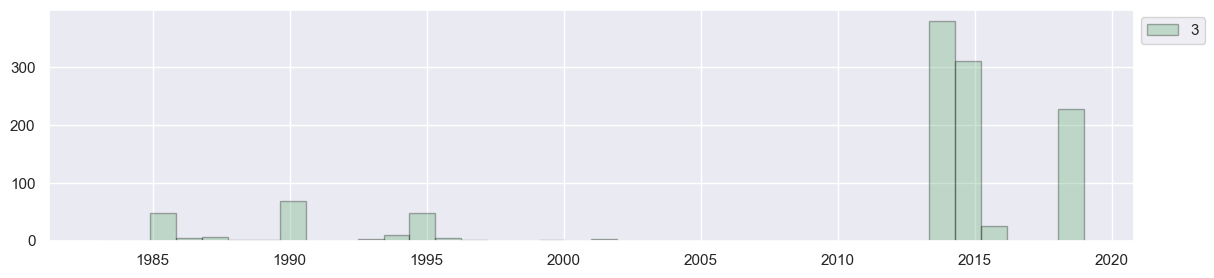

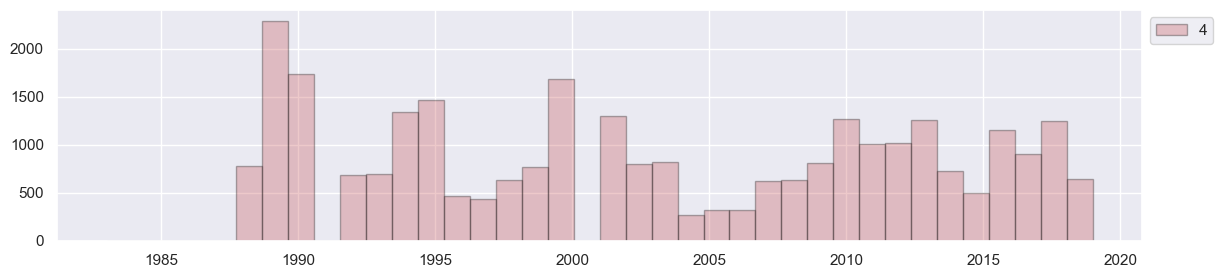

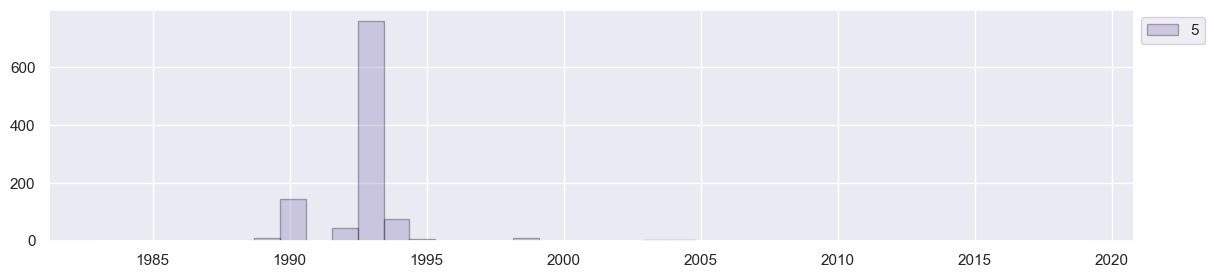

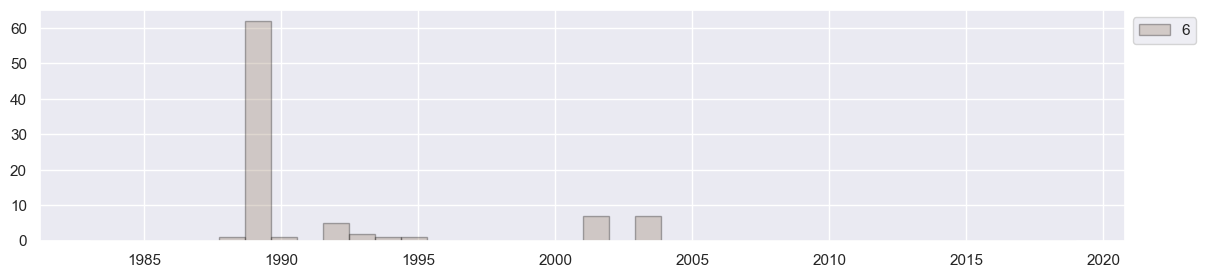

In [35]:
# why did maturity distributions change in the 90s?
# should we do anything to clean this?

possible_maturity = [1, 2, 3, 4, 5, 6]

for i, maturity in enumerate(possible_maturity):

    plt.figure(figsize=(14, 3))
    xmin, xmax = 1983, 2019
    bins = 2019 - 1983 + 1
    bins_plot = [(x/(bins+1))*(xmax-xmin)+xmin for x in range(bins+2)] 

    df_FD.loc[df_FD.maturity_id == maturity, 'DATETIME'].dt.year.hist(alpha=0.3, bins=bins_plot, label=maturity, edgecolor='black', color=sns.color_palette()[i])
    
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

    plt.show()

# OBSOLETE (after switch Species to Catch on models.py)
##### Check if we can merge species into samples (like herring). ie, are there duplicates?

In [36]:
temp = df_FD.groupby(['sample_id', 'SPECIES']).count().reset_index()[['sample_id', 'SPECIES']]

In [37]:
temp[temp.duplicated('sample_id', keep=False)].reset_index(drop=True)

,sample_id,SPECIES
0,1984053012,A
1,1984053012,B
2,1984060112,A
3,1984060112,B
4,1984060312,A
...,...,...
752,3000060726,B
753,3000060926,A
754,3000060926,B
755,3010061141,A


In [38]:
# many samples have both species included
# SHOULD TRACK SPECIES AT A FISH DETAIL LEVEL, NOT SAMPLES
# THIS IS INCOMPATIBLE WITH HERRING METHOD
temp[temp.duplicated('sample_id', keep=False)].reset_index(drop=True).groupby('sample_id').count().shape[0]

369